# 1. Importing necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.util import ngrams
import time
import gensim
from gensim import corpora, models
from gensim.models import TfidfModel, KeyedVectors, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from gensim.similarities import SoftCosineSimilarity, SparseTermSimilarityMatrix, WordEmbeddingSimilarityIndex
from collections import Counter
from gensim.models import Word2Vec, CoherenceModel, Phrases
import gensim.downloader as api
import pyLDAvis
import pyLDAvis.gensim_models  

# 2. Reading the data

In [2]:
sdg12_tweets = pd.read_csv('cp-sdg12-tweets.csv', encoding = 'latin-1')
bn_tweets = pd.read_csv('cp-buynothing-tweets.csv', encoding = 'latin-1')

### 2.1 Inspecting data dimension

In [3]:
print('sdg12_tweets')
print(sdg12_tweets.shape)
print(sdg12_tweets.info())
print()
print('bn_tweets')
print(bn_tweets.shape)
print(bn_tweets.info())

sdg12_tweets
(4126, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4126 entries, 0 to 4125
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       4126 non-null   object
 1   content    4126 non-null   object
 2   username   4114 non-null   object
 3   likeCount  4126 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 129.1+ KB
None

bn_tweets
(935, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       935 non-null    object
 1   content    935 non-null    object
 2   username   934 non-null    object
 3   likeCount  935 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 29.3+ KB
None


In [4]:
sdg12_tweets.head()

date  \
0  2023-03-31 13:36:52+00:00   
1  2023-03-31 13:27:34+00:00   
2  2023-03-31 13:24:51+00:00   
3  2023-03-31 13:20:38+00:00   
4  2023-03-31 12:41:27+00:00   

                                             content              username  \
0  âWaste is only a waste, if we waste itâ A ...                Prachi   
1  Heute ist der! Hast du dir schon mal ÃÂ¼berle...             grek_0523   
2  @UNDPasiapac Well done on the Asia Pacific For...            Rebecc1994   
3  It is this time again in the year! The Asia-Pa...       TheInstitution9   
4   40% of food crops are lost through pests and ...  guardianesdelpaosaje   

   likeCount  
0          0  
1          1  
2          4  
3         14  
4          0

In [5]:
bn_tweets.head()

date  \
0  2023-03-31 13:36:52+00:00   
1  2023-03-29 18:29:09+00:00   
2  2023-02-24 11:11:33+00:00   
3  2023-02-03 07:51:10+00:00   
4  2023-01-30 12:17:18+00:00   

                                             content       username  likeCount  
0  #Buynothingday #buynothing #Attac Ich richte m...  Paul283064118          0  
1   #buyNothingDay(s) #buyNothing aka #finDeQuincena  latostadorano          3  
2  @lovetoknow Sounds like something from an info...   grace_alta29          1  
3  Maybe it's time for consumers to pile on #BuyN...    EdinaMerida          0  
4  Groundhog Day is coming. If everyone went on a...  kathleencd631          1

### 2.2 Removing rows with missing values and duplicates

In [6]:
sdg12_tweets = sdg12_tweets.dropna(axis = 0, inplace = False)
sdg12_tweets = sdg12_tweets.drop_duplicates(keep = 'first')
bn_tweets = bn_tweets.dropna(axis = 0, inplace = False)
bn_tweets = bn_tweets.drop_duplicates(keep = 'first')

In [14]:
print(sdg12_tweets.shape)
print(bn_tweets.shape)

(4114, 4)
(934, 4)


### 2.3 Changing datetime to date

In [7]:
sdg12_tweets['date'] = sdg12_tweets['date'].apply(lambda x: x[0:10])
bn_tweets['date'] = bn_tweets['date'].apply(lambda x: x[0:10])

In [16]:
sdg12_tweets.head()

date                                            content  \
0  2023-03-31  âWaste is only a waste, if we waste itâ A ...   
1  2023-03-31  Heute ist der! Hast du dir schon mal ÃÂ¼berle...   
2  2023-03-31  @UNDPasiapac Well done on the Asia Pacific For...   
3  2023-03-31  It is this time again in the year! The Asia-Pa...   
4  2023-03-31   40% of food crops are lost through pests and ...   

               username  likeCount  
0                Prachi          0  
1             grek_0523          1  
2            Rebecc1994          4  
3       TheInstitution9         14  
4  guardianesdelpaosaje          0

In [17]:
bn_tweets.head()

date                                            content  \
0  2023-03-31  #Buynothingday #buynothing #Attac Ich richte m...   
1  2023-03-29   #buyNothingDay(s) #buyNothing aka #finDeQuincena   
2  2023-02-24  @lovetoknow Sounds like something from an info...   
3  2023-02-03  Maybe it's time for consumers to pile on #BuyN...   
4  2023-01-30  Groundhog Day is coming. If everyone went on a...   

        username  likeCount  
0  Paul283064118          0  
1  latostadorano          3  
2   grace_alta29          1  
3    EdinaMerida          0  
4  kathleencd631          1

#### Making sure the attribute date has datetime data type

In [8]:
sdg12_tweets['date'] = pd.to_datetime(sdg12_tweets['date'], format = '%Y-%m-%d')
bn_tweets['date'] = pd.to_datetime(bn_tweets['date'], format = '%Y-%m-%d')

In [19]:
print('sdg12_tweets')
print(sdg12_tweets.shape)
print(sdg12_tweets.info())
print()
print('bn_tweets')
print(bn_tweets.shape)
print(bn_tweets.info())

sdg12_tweets
(4114, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4114 entries, 0 to 4125
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       4114 non-null   datetime64[ns]
 1   content    4114 non-null   object        
 2   username   4114 non-null   object        
 3   likeCount  4114 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 160.7+ KB
None

bn_tweets
(934, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 934 entries, 0 to 934
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       934 non-null    datetime64[ns]
 1   content    934 non-null    object        
 2   username   934 non-null    object        
 3   likeCount  934 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 36.5+ KB
None


In [20]:
print('Number of unique users who posted about SDG12:')
sdg12_tweets['username'].nunique()

Number of unique users who posted about SDG12:


2547

In [21]:
print('Number of unique users who posted about BN:')
bn_tweets['username'].nunique()

Number of unique users who posted about BN:


782

- dataframe of sdg12 tweets - 4059 entries with no missing value, posted by 2547 unqiue users <br>
- dataframe of bn tweets - 936 entries with no missing value, posted by 782 unique users

# 3. Exploratory data analysis

### 3.1 Date range

In [22]:
print(sdg12_tweets['date'].agg(['min','max']))

min   2021-06-01
max   2023-03-31
Name: date, dtype: datetime64[ns]


In [23]:
print(bn_tweets['date'].agg(['min','max']))

min   2021-06-02
max   2023-03-31
Name: date, dtype: datetime64[ns]


### 3.2 Like count

In [9]:
def map_likeCount(likes):
    if likes == 0:
        return '0'
    elif likes >= 1 and likes <= 5:
        return '1 to 5'
    elif likes >= 6 and likes <= 10:
        return '6 to 10'
    elif likes >= 11 and likes <= 20:
        return '11 to 20'
    else:
        return '> 20'

In [10]:
sdg12_tweets['likeCountGroup'] = sdg12_tweets['likeCount'].apply(map_likeCount)
bn_tweets['likeCountGroup'] = bn_tweets['likeCount'].apply(map_likeCount)

#### Distribution of like counts - SDG12 tweets

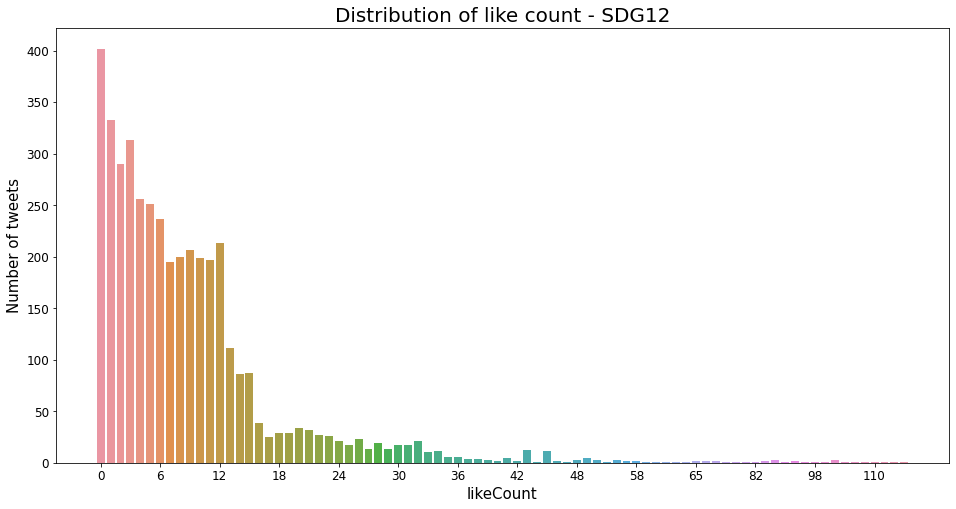

In [11]:
plt.figure(figsize = (16,8))
sns.countplot(x ='likeCount', data = sdg12_tweets)
plt.locator_params(axis = 'x', nbins = 15)
plt.title('Distribution of like count - SDG12', fontsize = 20)
plt.xlabel('likeCount', fontsize = 15)
plt.ylabel('Number of tweets', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

In [12]:
like_category_sdg12 = sdg12_tweets['likeCountGroup'].value_counts()

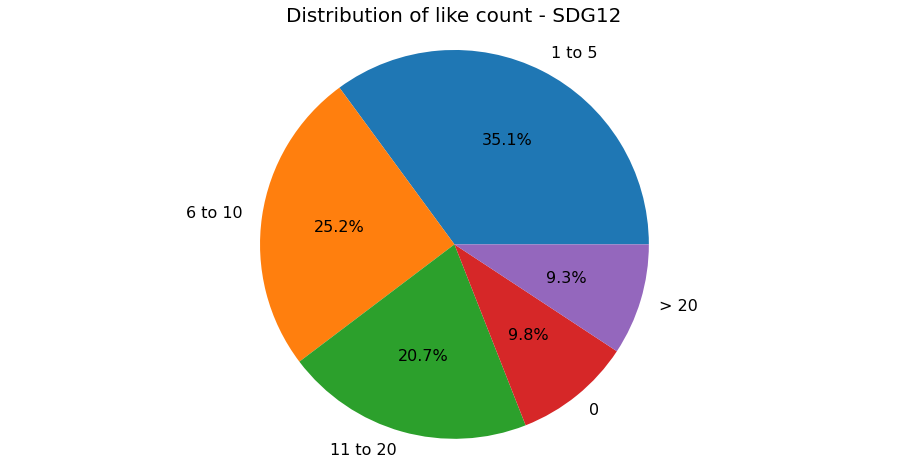

In [28]:
# pie chart of like count - SDG12
plt.figure(figsize = (16,8))
plt.pie(like_category_sdg12, labels = like_category_sdg12.index, 
        autopct = '%1.1f%%', textprops = {'fontsize': 16})
plt.title('Distribution of like count - SDG12', fontsize = 20)
plt.axis('equal')
plt.show()

In [29]:
print('bn_tweets')
sdg12_tweets['likeCount'].describe()

bn_tweets


C:\Users\chenyi\anaconda3\lib\site-packages\pandas\core\nanops.py:1723: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=1, interpolation=interpolation)


count    4114.000000
mean        9.116675
std        11.583773
min         0.000000
25%         3.000000
50%         6.000000
75%        12.000000
max       207.000000
Name: likeCount, dtype: float64

#### Distribution of like counts - BN tweets

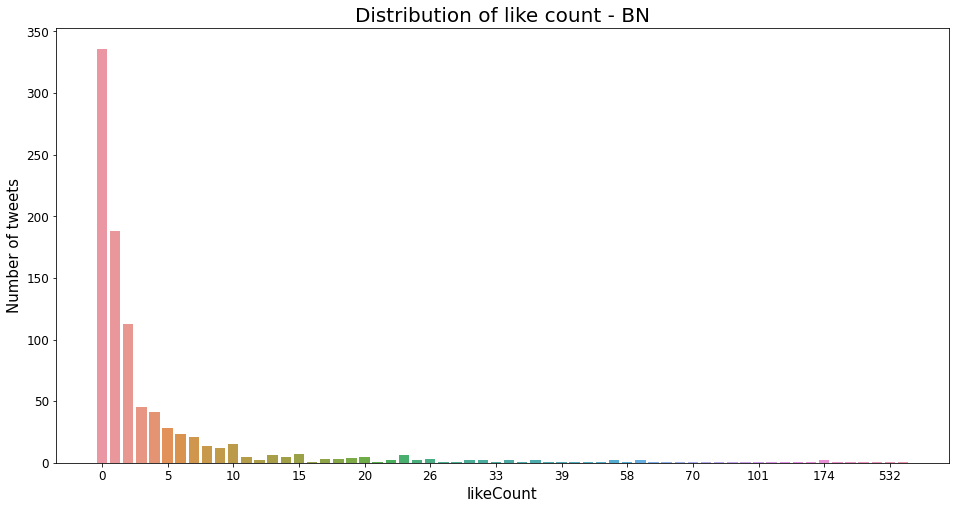

In [30]:
plt.figure(figsize = (16,8))
sns.countplot(x ='likeCount', data = bn_tweets)
plt.locator_params(axis = 'x', nbins = 15)
plt.title('Distribution of like count - BN', fontsize = 20)
plt.xlabel('likeCount', fontsize = 15)
plt.ylabel('Number of tweets', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

In [13]:
like_category_bn = bn_tweets['likeCountGroup'].value_counts()

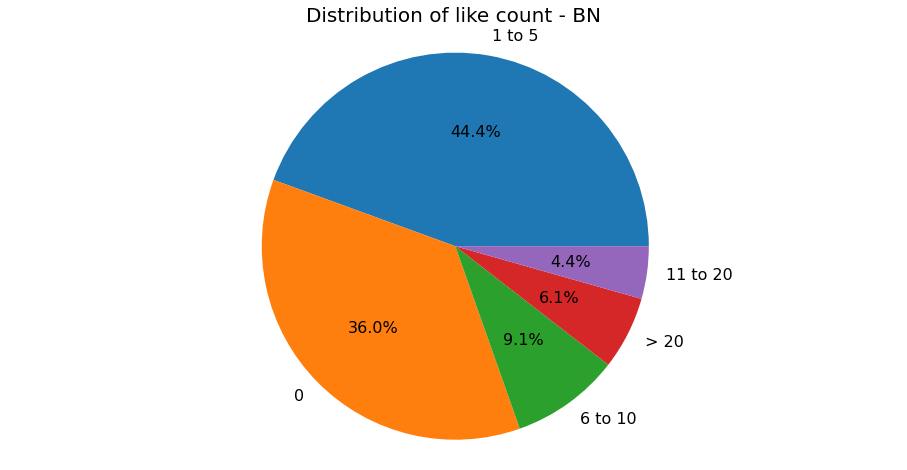

In [32]:
# pie chart of like count - BN
plt.figure(figsize = (16,8))
plt.pie(like_category_bn, labels = like_category_bn.index, 
        autopct = '%1.1f%%', textprops = {'fontsize': 16})
plt.title('Distribution of like count - BN', fontsize = 20)
plt.axis('equal')
plt.show()

In [33]:
print('bn_tweets')
bn_tweets['likeCount'].describe()

bn_tweets


C:\Users\chenyi\anaconda3\lib\site-packages\pandas\core\nanops.py:1723: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=1, interpolation=interpolation)


count    934.000000
mean       7.603854
std       34.224550
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max      591.000000
Name: likeCount, dtype: float64

### 3.3 Hashtag

#### Extract hashtags into a new column

In [14]:
sdg12_tweets['hashtag'] = sdg12_tweets['content'].str.findall(r'(\#\w+)')
bn_tweets['hashtag'] = bn_tweets['content'].str.findall(r'(\#\w+)')

#### Convert all hashtags into lowercase

In [15]:
sdg12_tweets['hashtag'] = sdg12_tweets['hashtag'].apply(lambda x: [hashtag.lower()
                                                                  for hashtag in x])
bn_tweets['hashtag'] = bn_tweets['hashtag'].apply(lambda x: [hashtag.lower()
                                                                  for hashtag in x])

In [36]:
sdg12_tweets.head()

date                                            content  \
0 2023-03-31  âWaste is only a waste, if we waste itâ A ...   
1 2023-03-31  Heute ist der! Hast du dir schon mal ÃÂ¼berle...   
2 2023-03-31  @UNDPasiapac Well done on the Asia Pacific For...   
3 2023-03-31  It is this time again in the year! The Asia-Pa...   
4 2023-03-31   40% of food crops are lost through pests and ...   

               username  likeCount likeCountGroup  \
0                Prachi          0              0   
1             grek_0523          1         1 to 5   
2            Rebecc1994          4         1 to 5   
3       TheInstitution9         14       11 to 20   
4  guardianesdelpaosaje          0              0   

                                             hashtag  
0  [#saynotoconsumerism, #sustainable, #sdg, #sdg...  
1  [#konsumverhalten, #anticonsumerism, #buyless,...  
2                    [#globalaction, #sdg12, #sdg13]  
3       [#sdg, #sdg6, #sdg9, #sdg12, #sdg13, #apfsd]  
4                       [#sdg12, #foodwastage, #scp]

In [16]:
print('Frequently-used hashtags in SDG12 tweets')
sdg12_hashtags = Counter([item for sublist in sdg12_tweets['hashtag'] for item in sublist])
sdg12_top_hashtags = pd.DataFrame(sdg12_hashtags.most_common(20))
sdg12_top_hashtags.columns = ['Top hashtags', 'Frequency']
sdg12_top_hashtags.style.background_gradient(cmap = 'Blues')

Frequently-used hashtags in SDG12 tweets


In [17]:
print('Frequently-used hashtags in BN tweets')
bn_hashtags = Counter([item for sublist in bn_tweets['hashtag'] for item in sublist])
bn_top_hashtags = pd.DataFrame(bn_hashtags.most_common(20))
bn_top_hashtags.columns = ['Top hashtags', 'Frequency']
bn_top_hashtags.style.background_gradient(cmap = 'Purples')

Frequently-used hashtags in BN tweets


In [18]:
# Check hashtags like bnp and bna
bn_tweets[bn_tweets['hashtag'].apply(lambda x: '#buynothingproject' in x)]

date                                            content  \
435 2022-02-11  Have you seen this in your community? \n\nHere...   
898 2021-11-22  The Buy Nothing Project is committed to reduci...   

          username  likeCount likeCountGroup  \
435  NewsFromNikki          1         1 to 5   
898     gipsyblood          0              0   

                                               hashtag  
435  [#buynothing, #buynothingnew, #buynothingday, ...  
898  [#buynothingproject, #buynothingday, #buynothing]

In [16]:
# Check hashtags like bnp and bna
sdg12_tweets[sdg12_tweets['hashtag'].apply(lambda x: '#buynothingproject' in x)]

Empty DataFrame
Columns: [date, content, username, likeCount, likeCountGroup, hashtag]
Index: []

Observation: There are very few, almost no hashtags mentioning about the BuyNothing App

### 3.4 Number of tweets X Date

### 3.4.1 Number of tweets by month

In [19]:
sdg12_tweets['yearMonth'] = sdg12_tweets['date'].dt.to_period('M')
bn_tweets['yearMonth'] = bn_tweets['date'].dt.to_period('M')

In [20]:
mean_tweets_sdg12 = sdg12_tweets.groupby('yearMonth').size().mean()
median_tweets_sdg12 = sdg12_tweets.groupby('yearMonth').size().median()
print('SDG12 Year-Month Tweets')
print('mean:' , mean_tweets_sdg12)
print('median:' , median_tweets_sdg12)

SDG12 Year-Month Tweets
mean: 187.0
median: 142.0


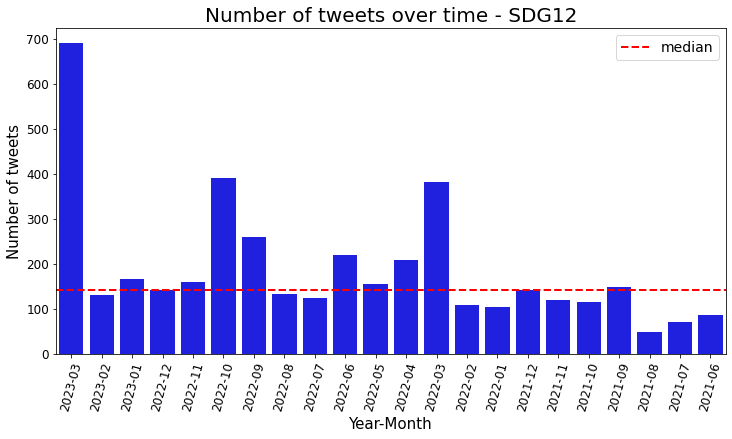

In [21]:
# bar chart of number of tweets by year-month - SDG12
plt.figure(figsize=(12, 6))
sns.countplot(x = 'yearMonth', data = sdg12_tweets, color = 'blue')
plt.title('Number of tweets over time - SDG12', fontsize = 20)
plt.xlabel('Year-Month', fontsize = 15)
plt.ylabel('Number of tweets', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 75)
plt.yticks(fontsize = 12)
plt.axhline(y = median_tweets_sdg12, linestyle = '--', linewidth = 2, label = 'median', color = 'red')
plt.legend(fontsize = 14)
plt.show()

Months with high volume of discussions: <br>
- March 2023
- October 2022
- September 2022
- June 2022
- April 2022
- March 2022

In [22]:
mean_tweets_bn = bn_tweets.groupby('yearMonth').size().mean()
median_tweets_bn = bn_tweets.groupby('yearMonth').size().median()
print('BN Year-Month Tweets')
print('mean:' , mean_tweets_bn)
print('median:' , median_tweets_bn)

BN Year-Month Tweets
mean: 49.1578947368421
median: 4.0


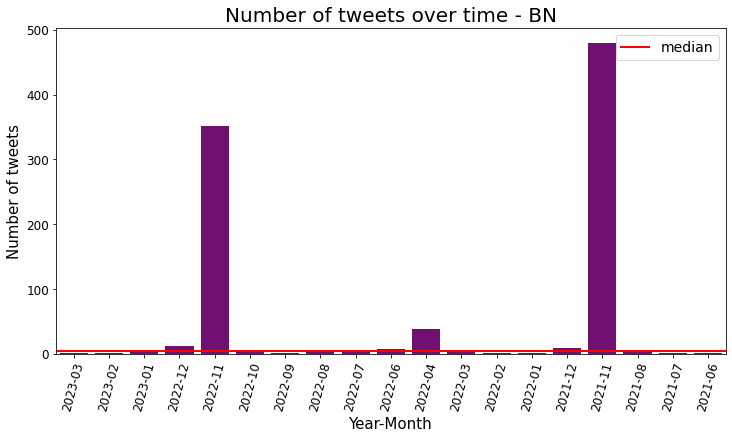

In [23]:
# bar chart of number of tweets by year-month - BN
plt.figure(figsize=(12, 6))
sns.countplot(x = 'yearMonth', data = bn_tweets, color = 'purple')
plt.title('Number of tweets over time - BN', fontsize = 20)
plt.xlabel('Year-Month', fontsize = 15)
plt.ylabel('Number of tweets', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 75)
plt.yticks(fontsize = 12)
plt.axhline(y = median_tweets_bn, linewidth = 2, label = 'median', color = 'red')
plt.legend(fontsize = 14, loc = 1)
plt.show()

Months with high volume of discussions: <br>
- November 2022

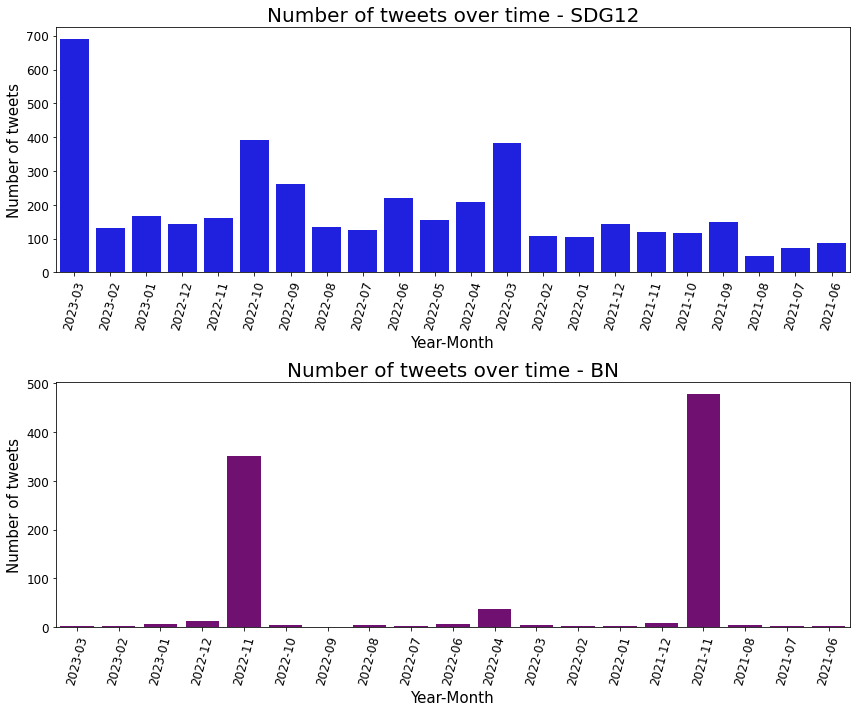

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

sns.countplot(x = 'yearMonth', data = sdg12_tweets, color = 'blue', ax = ax1)
ax1.set_title('Number of tweets over time - SDG12', fontsize = 20)
ax1.set_xlabel('Year-Month', fontsize = 15)
ax1.set_ylabel('Number of tweets', fontsize = 15)
ax1.tick_params(axis = 'x', labelrotation = 75)
ax1.tick_params(axis = 'both', labelsize = 12)

sns.countplot(x = 'yearMonth', data = bn_tweets, color = 'purple', ax = ax2)
ax2.set_title('Number of tweets over time - BN', fontsize = 20)
ax2.set_xlabel('Year-Month', fontsize = 15)
ax2.set_ylabel('Number of tweets', fontsize = 15)
ax2.tick_params(axis = 'x', labelrotation = 75)
ax2.tick_params(axis = 'both', labelsize = 12)

plt.tight_layout()

plt.show()

### 3.4.2 Number of tweets by day - identify special events

#### March 2023 (SDG12)

In [24]:
sdg12_tweets['date_trunc'] = sdg12_tweets['date'].dt.date
bn_tweets['date_trunc'] = bn_tweets['date'].dt.date

In [25]:
sdg12_2023march = sdg12_tweets[sdg12_tweets['yearMonth'] == '2023-03']

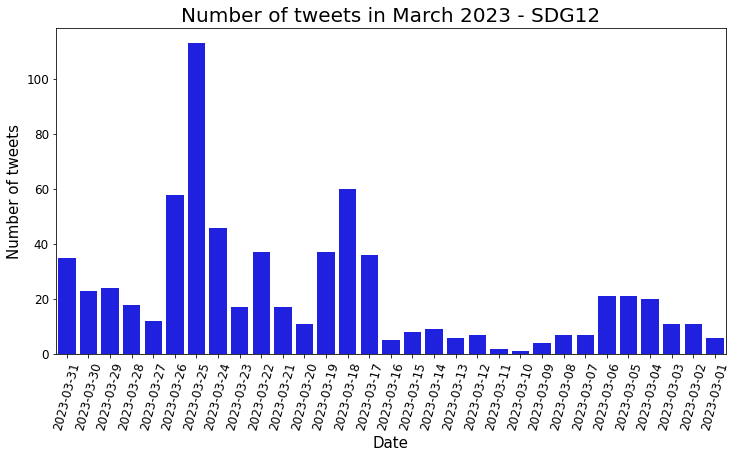

In [49]:
# bar chart of number of tweets in March 2023 - SDG12
plt.figure(figsize = (12, 6))
sns.countplot(x = 'date_trunc', data = sdg12_2023march, color = 'blue')
plt.title('Number of tweets in March 2023 - SDG12', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Number of tweets', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 75)
plt.yticks(fontsize = 12)
plt.show()

Note: 25 March 2023 is the day of Earth Hour

#### October 2022 (SDG12)

In [26]:
sdg12_2022october = sdg12_tweets[sdg12_tweets['yearMonth'] == '2022-10']

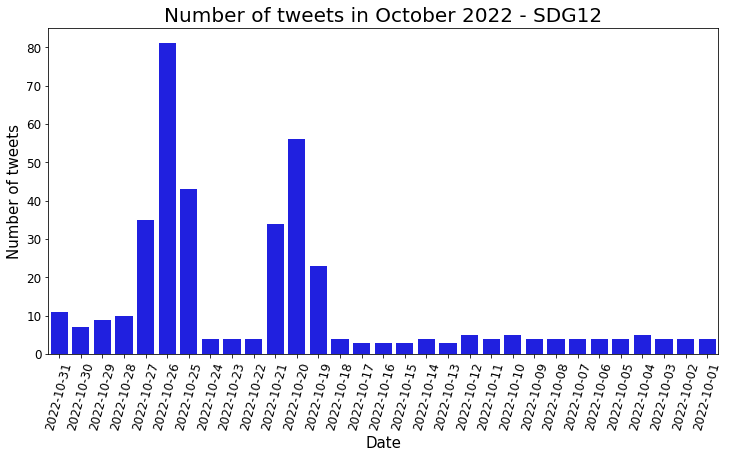

In [51]:
# bar chart of number of tweets in October 2022 - SDG12
plt.figure(figsize = (12, 6))
sns.countplot(x = 'date_trunc', data = sdg12_2022october, color = 'blue')
plt.title('Number of tweets in October 2022 - SDG12', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Number of tweets', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 75)
plt.yticks(fontsize = 12)
plt.show()

Note: <br>
- 26 October 2022 is Sustainability Day
- 20 October 2022 is National Reuse Day

#### September 2022 (SDG12)

In [27]:
sdg12_2022september = sdg12_tweets[sdg12_tweets['yearMonth'] == '2022-09']

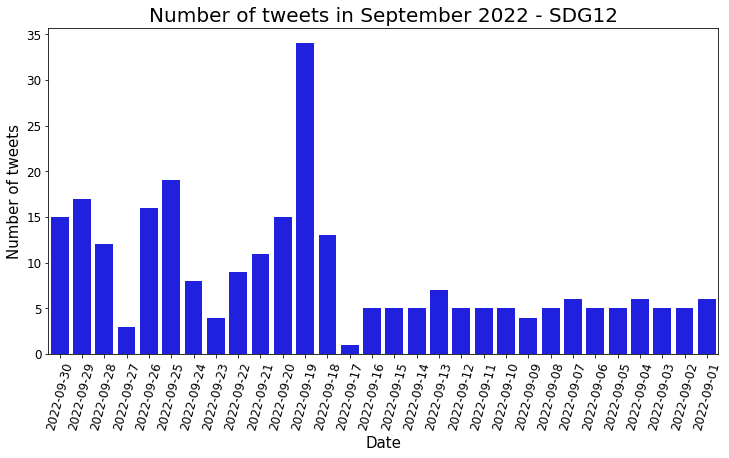

In [53]:
# bar chart of number of tweets in September 2022 - SDG12
plt.figure(figsize = (12, 6))
sns.countplot(x = 'date_trunc', data = sdg12_2022september, color = 'blue')
plt.title('Number of tweets in September 2022 - SDG12', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Number of tweets', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 75)
plt.yticks(fontsize = 12)
plt.show()

Note: <br>
- 29 September 2022 is International Day of Awareness of Food Loss and Waste
- 25 September 2022 is Global Day of Climate Action
- 21 September 2022 is Zero Emission Day
- 19 September 2022 is SDG Moment 

#### June 2022 (SDG12)

In [28]:
sdg12_2022june = sdg12_tweets[sdg12_tweets['yearMonth'] == '2022-06']

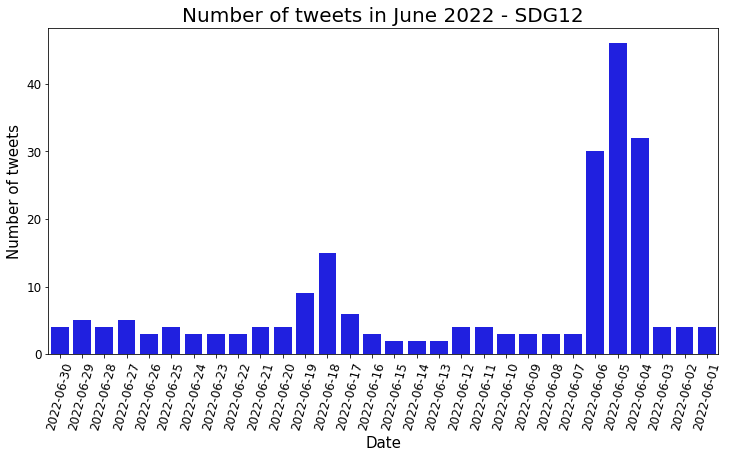

In [55]:
# bar chart of number of tweets in June 2022 - SDG12
plt.figure(figsize = (12, 6))
sns.countplot(x = 'date_trunc', data = sdg12_2022june, color = 'blue')
plt.title('Number of tweets in June 2022 - SDG12', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Number of tweets', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 75)
plt.yticks(fontsize = 12)
plt.show()

Note: <br>
- 18 June 2022 is Sustainable Gastronomy Day
- 5 June 2022 is Word Environment Day

#### April 2022 (SDG12)

In [29]:
sdg12_2022april = sdg12_tweets[sdg12_tweets['yearMonth'] == '2022-04']

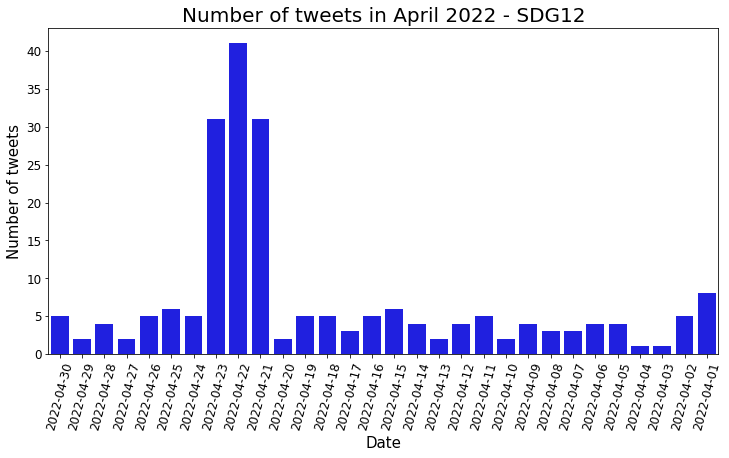

In [57]:
# bar chart of number of tweets in April 2022 - SDG12
plt.figure(figsize = (12, 6))
sns.countplot(x = 'date_trunc', data = sdg12_2022april, color = 'blue')
plt.title('Number of tweets in April 2022 - SDG12', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Number of tweets', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 75)
plt.yticks(fontsize = 12)
plt.show()

Note: <br>
- 22 April 2022 is Earth Day

#### Nov 2022 (BN)

In [30]:
bn_2022nov = bn_tweets[bn_tweets['yearMonth'] == '2022-11']

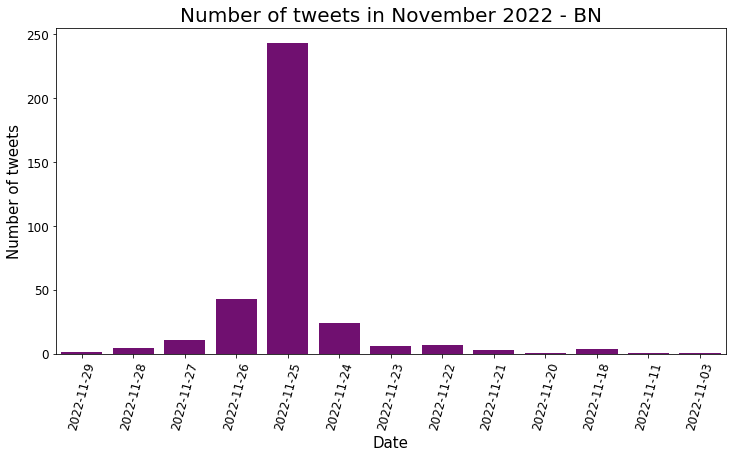

In [59]:
# bar chart of number of tweets in November 2022 - BN
plt.figure(figsize = (12, 6))
sns.countplot(x = 'date_trunc', data = bn_2022nov, color = 'purple')
plt.title('Number of tweets in November 2022 - BN', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Number of tweets', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 75)
plt.yticks(fontsize = 12)
plt.show()

Note: 25 November 2022 is Black Friday and Buy Nothing Day

#### Nov 2021 (BN)

In [31]:
bn_2021nov = bn_tweets[bn_tweets['yearMonth'] == '2021-11']

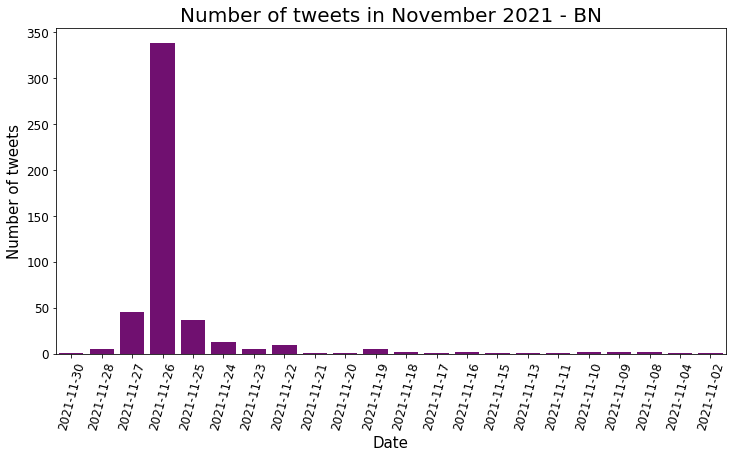

In [61]:
# bar chart of number of tweets in November 2021 - BN
plt.figure(figsize = (12, 6))
sns.countplot(x = 'date_trunc', data = bn_2021nov, color = 'purple')
plt.title('Number of tweets in November 2021 - BN', fontsize = 20)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Number of tweets', fontsize = 15)
plt.xticks(fontsize = 12, rotation = 75)
plt.yticks(fontsize = 12)
plt.show()

# 4. Data processing

### 4.1.1 Text cleaning

In [32]:
def text_cleaning(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+|(\w+:\/\/\S+)', '', text)  # remove url
    text = re.sub(r'@[^\s]+','', text)  # remove @mention
    text = re.sub(r'\B#\S+','', text)  # remove #hastag
    text = re.sub(r'\w*\d\w*', '', text)  # remove aphanumeric character
    text = re.sub(r'\d+', '', text)  # remove numeric character
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # remove special character
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\n', '', text) # remove empty line
    return text

### 4.1.2 Tokenization

In [33]:
def tokenization(text):
    tokens = nltk.word_tokenize(text)
    return tokens

### 4.1.2 Remove stopwords

In [34]:
sw = stopwords.words('english')
sw2 = ['u', 'let', 'le', 'dont']
sw.extend(sw2)

def remove_stopwords(text):
    return [token for token in text if token not in sw]

### 4.1.4 Lemmatization

In [35]:
lemmatizer = WordNetLemmatizer()

def lemmatization(text):
    lemm_text = [lemmatizer.lemmatize(token) for token in text]
    return lemm_text

#### Cleaning SDG12 tweets

In [36]:
sdg12_tweets['content_cleaned'] = sdg12_tweets['content'].apply(lambda x: text_cleaning(x))
sdg12_tweets['content_cleaned'] = sdg12_tweets['content_cleaned'].apply(lambda x: tokenization(x))
sdg12_tweets['content_cleaned'] = sdg12_tweets['content_cleaned'].apply(lambda x: remove_stopwords(x))
sdg12_tweets['content_cleaned'] = sdg12_tweets['content_cleaned'].apply(lambda x: lemmatization(x))
sdg12_tweets['content_cleaned'] = sdg12_tweets['content_cleaned'].apply(lambda x: remove_stopwords(x))

In [67]:
sdg12_tweets.head()

date                                            content  \
0 2023-03-31  âWaste is only a waste, if we waste itâ A ...   
1 2023-03-31  Heute ist der! Hast du dir schon mal ÃÂ¼berle...   
2 2023-03-31  @UNDPasiapac Well done on the Asia Pacific For...   
3 2023-03-31  It is this time again in the year! The Asia-Pa...   
4 2023-03-31   40% of food crops are lost through pests and ...   

               username  likeCount likeCountGroup  \
0                Prachi          0              0   
1             grek_0523          1         1 to 5   
2            Rebecc1994          4         1 to 5   
3       TheInstitution9         14       11 to 20   
4  guardianesdelpaosaje          0              0   

                                             hashtag yearMonth  date_trunc  \
0  [#saynotoconsumerism, #sustainable, #sdg, #sdg...   2023-03  2023-03-31   
1  [#konsumverhalten, #anticonsumerism, #buyless,...   2023-03  2023-03-31   
2                    [#globalaction, #sdg12, #sdg13]   2023-03  2023-03-31   
3       [#sdg, #sdg6, #sdg9, #sdg12, #sdg13, #apfsd]   2023-03  2023-03-31   
4                       [#sdg12, #foodwastage, #scp]   2023-03  2023-03-31   

                                     content_cleaned  
0  [waste, waste, waste, beautiful, collage, reus...  
1  [heute, ist, der, hast, du, dir, schon, mal, b...  
2  [well, done, asia, pacific, forum, sustainable...  
3  [time, year, asiapacific, forum, sustainable, ...  
4  [food, crop, lost, pest, plant, disease, food,...

In [54]:
sdg12_tweets[['content','content_cleaned']]

content  \
0     âWaste is only a waste, if we waste itâ A ...   
1     Heute ist der! Hast du dir schon mal ÃÂ¼berle...   
2     @UNDPasiapac Well done on the Asia Pacific For...   
3     It is this time again in the year! The Asia-Pa...   
4      40% of food crops are lost through pests and ...   
...                                                 ...   
4121  World Environment Day serves as a catalyst for...   
4122  #WorldEnvironemntalDay emphasizes the need for...   
4123  In the #WorldEnvironmentalDay2021 the 2on and ...   
4124  World Environmental Day is the perfect opportu...   
4125  Spread awareness about sustainable consumption...   

                                        content_cleaned  
0     [waste, waste, waste, beautiful, collage, reus...  
1     [heute, ist, der, hast, du, dir, schon, mal, b...  
2     [well, done, asia, pacific, forum, sustainable...  
3     [time, year, asiapacific, forum, sustainable, ...  
4     [food, crop, lost, pest, plant, disease, food,...  
...                                                 ...  
4121  [world, environment, day, serf, catalyst, prom...  
4122  [emphasizes, need, sustainable, development, r...  
4123  [five, way, conserve, natural, resource, home,...  
4124  [world, environmental, day, perfect, opportuni...  
4125  [spread, awareness, sustainable, consumption, ...  

[4114 rows x 2 columns]

#### Cleaning BN tweets

In [37]:
bn_tweets['content_cleaned'] = bn_tweets['content'].apply(lambda x: text_cleaning(x))
bn_tweets['content_cleaned'] = bn_tweets['content_cleaned'].apply(lambda x: tokenization(x))
bn_tweets['content_cleaned'] = bn_tweets['content_cleaned'].apply(lambda x: remove_stopwords(x))
bn_tweets['content_cleaned'] = bn_tweets['content_cleaned'].apply(lambda x: lemmatization(x))
bn_tweets['content_cleaned'] = bn_tweets['content_cleaned'].apply(lambda x: remove_stopwords(x))

In [69]:
bn_tweets.head()

date                                            content  \
0 2023-03-31  #Buynothingday #buynothing #Attac Ich richte m...   
1 2023-03-29   #buyNothingDay(s) #buyNothing aka #finDeQuincena   
2 2023-02-24  @lovetoknow Sounds like something from an info...   
3 2023-02-03  Maybe it's time for consumers to pile on #BuyN...   
4 2023-01-30  Groundhog Day is coming. If everyone went on a...   

        username  likeCount likeCountGroup  \
0  Paul283064118          0              0   
1  latostadorano          3         1 to 5   
2   grace_alta29          1         1 to 5   
3    EdinaMerida          0              0   
4  kathleencd631          1         1 to 5   

                                             hashtag yearMonth  date_trunc  \
0              [#buynothingday, #buynothing, #attac]   2023-03  2023-03-31   
1      [#buynothingday, #buynothing, #findequincena]   2023-03  2023-03-29   
2  [#buynothingday, #buynothing, #inventsomething...   2023-02  2023-02-24   
3                      [#buynothingday, #buynothing]   2023-02  2023-02-03   
4                      [#buynothingday, #buynothing]   2023-01  2023-01-30   

                                     content_cleaned  
0  [ich, richte, mir, drei, tagewoche, wo, ich, n...  
1                                              [aka]  
2  [sound, like, something, infomercial, cant, pe...  
3                      [maybe, time, consumer, pile]  
4  [groundhog, day, coming, everyone, went, spend...

## Frequently-used words

#### Frequently-used words in SDG12 tweets

In [38]:
print('Frequently used words in SDG12 tweets')
sdg12_top_words = Counter([item for sublist in sdg12_tweets['content_cleaned'] for item in sublist])
sdg12_top_df = pd.DataFrame(sdg12_top_words.most_common(20))
sdg12_top_df.columns = ['Top words', 'Frequency']
sdg12_top_df.style.background_gradient(cmap = 'Blues')

Frequently used words in SDG12 tweets


#### Frequently-used words in BN tweets

In [39]:
print('Frequently-used words in BN tweets')
bn_top_words = Counter([item for sublist in bn_tweets['content_cleaned'] for item in sublist])
bn_top_df = pd.DataFrame(bn_top_words.most_common(20))
bn_top_df.columns = ['Top words', 'Frequency']
bn_top_df.style.background_gradient(cmap = 'Purples')

Frequently-used words in BN tweets


In [40]:
fig = px.bar(sdg12_top_df, x = 'Frequency', y = 'Top words', title = 'Commmon Words in SDG12 tweets', orientation = 'h', 
             width = 700, height = 700, color = 'Top words')

fig.show()

In [41]:
fig = px.bar(bn_top_df, x = 'Frequency', y = 'Top words', title = 'Commmon Words in BuyNothing tweets', orientation = 'h', 
             width = 700, height = 700, color = 'Top words')

fig.show()

## Wordcloud

In [42]:
sdg12_string = ' '.join([token for sublist in sdg12_tweets['content_cleaned'] 
                         for token in sublist])
bn_string = ' '.join([token for sublist in bn_tweets['content_cleaned'] 
                         for token in sublist])

#### Wordcloud for SDG12 tweets

In [43]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

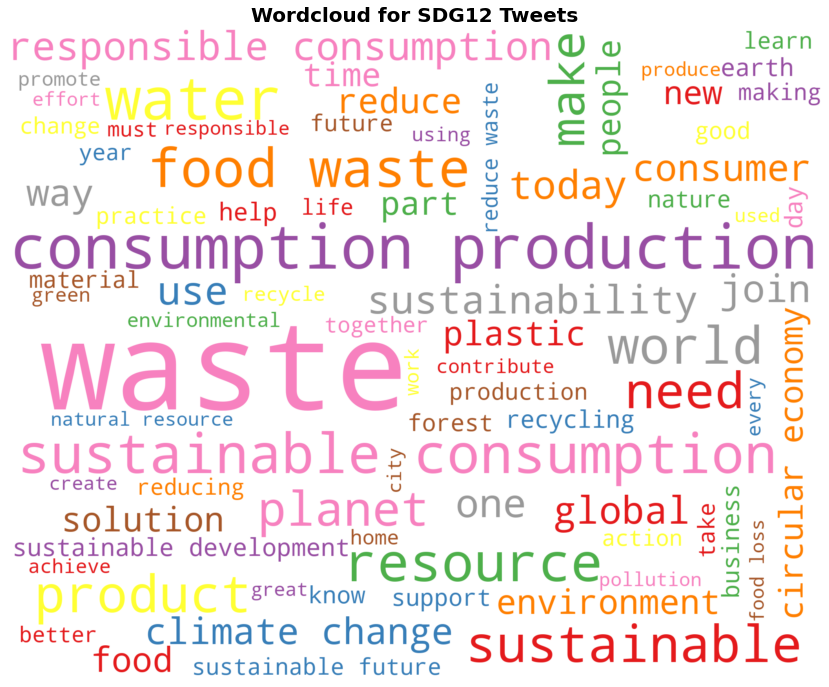

In [76]:
plt.figure(figsize = (20,12))
sdg12_wordcloud = WordCloud(background_color = 'white', stopwords = STOPWORDS, max_words = 80, 
                            max_font_size = 300, min_font_size = 40, 
                            width = 2000, height = 1600).generate(sdg12_string)
plt.imshow(sdg12_wordcloud.recolor(colormap = 'Set1' , random_state = 46), interpolation = 'bilinear')
plt.title('Wordcloud for SDG12 Tweets', fontsize = 20, fontweight = 'bold')
plt.axis('off')
plt.show()

#### Wordcloud for BN tweets

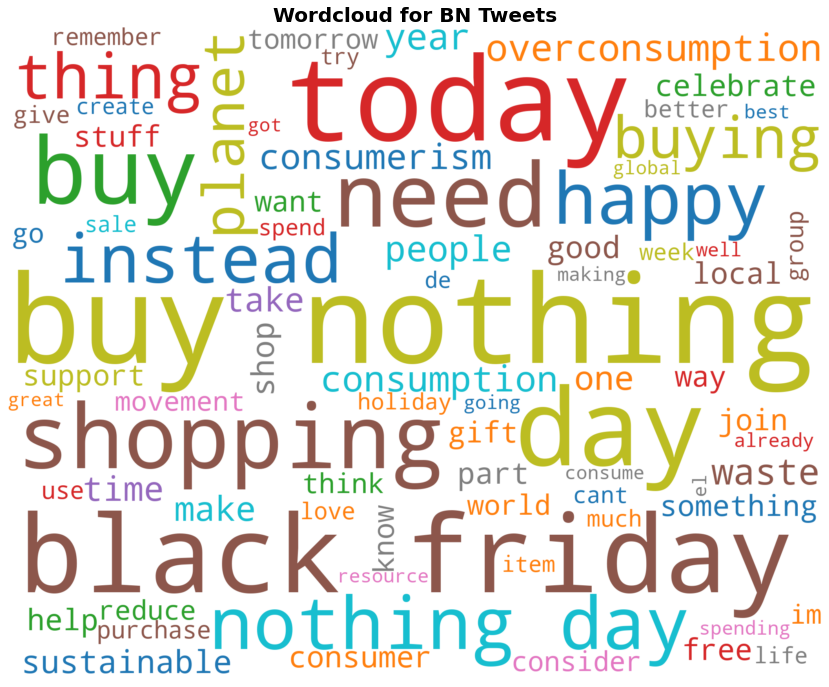

In [77]:
plt.figure(figsize = (20,12))
bn_wordcloud = WordCloud(background_color = 'white', stopwords = STOPWORDS, max_words = 80, 
                            max_font_size = 300, min_font_size = 40, 
                            width = 2000, height = 1600).generate(bn_string)
plt.imshow(bn_wordcloud.recolor(colormap = 'tab10' , random_state = 46), interpolation = 'bilinear')
plt.title('Wordcloud for BN Tweets', fontsize = 20, fontweight = 'bold')
plt.axis('off')
plt.show()

# 5. Sentiment Analysis

In [44]:
# download VADER lexicon and sentiment analyzer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chenyi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 5.1 Text processing for VADER Sentiment Analysis

Note: Text processing here <br>
- does not remove punctuations, only remove special characters like # $ % & * <br>
- does not perform case normalization <br>
- does not remove stopwords <br>
because VADER S.A. considers capitalization and punctuations when producing sentiment scores 

In [45]:
def text_cleaning_sa(text):
    text = re.sub(r'https?://\S+|www\.\S+|(\w+:\/\/\S+)', '', text)  # remove url
    text = re.sub(r'@[^\s]+','', text)  # remove @mention
    text = re.sub(r'\B#\S+','', text)  # remove #hastag
    text = re.sub(r'\w*\d\w*', '', text)  # remove alphanumeric character
    text = re.sub(r'\d+', '', text)  # remove numeric character
    text = re.sub(r'\n', '', text) # remove empty line
    return text

In [46]:
def tokenization(text):
    tokens = nltk.word_tokenize(text)
    return tokens

In [47]:
sw = stopwords.words('english')
sw2 = ['u', 'let', 'le', 'dont', '$', '@', '#', '$', '%', '*', '(', ')', ' ¦', ' €', 'Ã', '"']
sw.extend(sw2)

def remove_stopwords_sa(text):
    text = [word for word in text if word.lower() not in sw]
    text = ' '.join(text)
    return text

In [48]:
# duplicate the datasets for analysis
sdg12_dup = sdg12_tweets.copy()
bn_dup = bn_tweets.copy()

In [49]:
# text cleaning, tokenization, stopwords removal
sdg12_dup['content_cleaned_sa'] = sdg12_dup['content'].apply(lambda x: text_cleaning_sa(x))
sdg12_dup['content_cleaned_sa'] = sdg12_dup['content_cleaned_sa'].apply(lambda x: tokenization(x))
sdg12_dup['content_cleaned_sa'] = sdg12_dup['content_cleaned_sa'].apply(lambda x: remove_stopwords_sa(x))
bn_dup['content_cleaned_sa'] = bn_dup['content'].apply(lambda x: text_cleaning_sa(x))
bn_dup['content_cleaned_sa'] = bn_dup['content_cleaned_sa'].apply(lambda x: tokenization(x))
bn_dup['content_cleaned_sa'] = bn_dup['content_cleaned_sa'].apply(lambda x: remove_stopwords_sa(x))

### 5.2 VADER Sentiment Analysis

### 5.2.1 Computing sentiment score and polarity

Note: <br>
Text with <br>
- compound sentiment score >= 0.05 is Positive <br>
- compound sentiment score <= -0.05 is Negative <br>
- -0.05 < compound sentiment score < 0.05 is Neutral <br>

- positiveSentiment and negativeSentiment indicate the possibilities of each text being positive or negative

In [50]:
# initialise the sentiment intensity analyser
VADER_analyser = SIA()

#### VADER Sentiment Analysis on SDG12 tweets

In [51]:
# extract the compound, positive, negative, and neutral score into their respective columns
sdg12_dup['compoundSentiment'] = sdg12_dup['content_cleaned_sa'].apply(lambda x: VADER_analyser.polarity_scores(' '.join(re.findall(r'\w+', x)))['compound'])
sdg12_dup['positiveSentiment'] = sdg12_dup['content_cleaned_sa'].apply(lambda x: VADER_analyser.polarity_scores(' '.join(re.findall(r'\w+', x)))['pos'])
sdg12_dup['negativeSentiment'] = sdg12_dup['content_cleaned_sa'].apply(lambda x: VADER_analyser.polarity_scores(' '.join(re.findall(r'\w+', x)))['neg'])
sdg12_dup['neutralSentiment'] = sdg12_dup['content_cleaned_sa'].apply(lambda x: VADER_analyser.polarity_scores(' '.join(re.findall(r'\w+', x)))['neu'])

In [52]:
# classify sentiment polarity
conditions = [
    (sdg12_dup['compoundSentiment'] > 0.05),
    (sdg12_dup['compoundSentiment'] < -0.05),
    (sdg12_dup['compoundSentiment'] == 0.00),
    (sdg12_dup['compoundSentiment'] >= -0.05) & (sdg12_dup['compoundSentiment'] <= 0.05)
]

compound_polarity = ['Positive', 'Negative', 'Neutral','Neutral']

In [53]:
# store sentiment polarity in a new column
sdg12_dup['sentimentPolarity'] = np.select(conditions, compound_polarity)

In [380]:
sdg12_dup[['content_cleaned','compoundSentiment','positiveSentiment','negativeSentiment','neutralSentiment','sentimentPolarity']].head()

content_cleaned  \
0                                                                                                                                                                         [waste, waste, waste, beautiful, collage, reuse, reduce, earth, abuse, made, ahlconites, live, sustainable, life]   
1                                                                                                                                                                                                    [heute, ist, der, hast, du, dir, schon, mal, berlegt, welche, konsequenzen, dein, hat]   
2                                                                                                                                                                                                                              [well, done, asia, pacific, forum, sustainable, development]   
3  [time, year, asiapacific, forum, sustainable, development, apfsd, aim, provide, global, community, transparency, understand, follow, progress, sustainable, development, goal, striving, achieve, identify, sustainabel, global, trend, best, practice, part, making, ambition, reality]   
4                                                                                                                   [food, crop, lost, pest, plant, disease, food, waste, first, link, chain, one, problem, targeted, responsible, consumption, production, aim, halve, end, food, wastage]   

   compoundSentiment  positiveSentiment  negativeSentiment  neutralSentiment  \
0            -0.5423              0.167              0.361             0.472   
1             0.0000              0.000              0.000             1.000   
2             0.2732              0.259              0.000             0.741   
3             0.7906              0.194              0.000             0.806   
4            -0.6705              0.082              0.278             0.641   

  sentimentPolarity  
0          Negative  
1           Neutral  
2          Positive  
3          Positive  
4          Negative

#### VADER Sentiment Analysis on BN tweets

In [54]:
# extract the compound, positive, negative, and neutral score into their respective columns
bn_dup['compoundSentiment'] = bn_dup['content_cleaned_sa'].apply(lambda x: VADER_analyser.polarity_scores(' '.join(re.findall(r'\w+', x)))['compound'])
bn_dup['positiveSentiment'] = bn_dup['content_cleaned_sa'].apply(lambda x: VADER_analyser.polarity_scores(' '.join(re.findall(r'\w+', x)))['pos'])
bn_dup['negativeSentiment'] = bn_dup['content_cleaned_sa'].apply(lambda x: VADER_analyser.polarity_scores(' '.join(re.findall(r'\w+', x)))['neg'])
bn_dup['neutralSentiment'] = bn_dup['content_cleaned_sa'].apply(lambda x: VADER_analyser.polarity_scores(' '.join(re.findall(r'\w+', x)))['neu'])

In [55]:
# classify sentiment polarity
conditions = [
    (bn_dup['compoundSentiment'] > 0.05),
    (bn_dup['compoundSentiment'] < -0.05),
    (bn_dup['compoundSentiment'] == 0.00),
    (bn_dup['compoundSentiment'] >= -0.05) & (bn_dup['compoundSentiment'] <= 0.05)
]

compound_polarity = ['Positive', 'Negative', 'Neutral','Neutral']

In [56]:
# store sentiment polarity in a new column
bn_dup['sentimentPolarity'] = np.select(conditions, compound_polarity)

In [93]:
bn_dup.head()

date                                            content  \
0 2023-03-31  #Buynothingday #buynothing #Attac Ich richte m...   
1 2023-03-29   #buyNothingDay(s) #buyNothing aka #finDeQuincena   
2 2023-02-24  @lovetoknow Sounds like something from an info...   
3 2023-02-03  Maybe it's time for consumers to pile on #BuyN...   
4 2023-01-30  Groundhog Day is coming. If everyone went on a...   

        username  likeCount likeCountGroup  \
0  Paul283064118          0              0   
1  latostadorano          3         1 to 5   
2   grace_alta29          1         1 to 5   
3    EdinaMerida          0              0   
4  kathleencd631          1         1 to 5   

                                             hashtag yearMonth  date_trunc  \
0              [#buynothingday, #buynothing, #attac]   2023-03  2023-03-31   
1      [#buynothingday, #buynothing, #findequincena]   2023-03  2023-03-29   
2  [#buynothingday, #buynothing, #inventsomething...   2023-02  2023-02-24   
3                      [#buynothingday, #buynothing]   2023-02  2023-02-03   
4                      [#buynothingday, #buynothing]   2023-01  2023-01-30   

                                     content_cleaned  \
0  [ich, richte, mir, drei, tagewoche, wo, ich, n...   
1                                              [aka]   
2  [sound, like, something, infomercial, cant, pe...   
3                      [maybe, time, consumer, pile]   
4  [groundhog, day, coming, everyone, went, spend...   

                                  content_cleaned_sa  compoundSentiment  \
0  Ich richte mir drei Tage/Woche , wo ich nichts...             0.0000   
1                                                aka             0.0000   
2  Sounds like something infomercial ! ca n't peo...             0.6597   
3                       Maybe 's time consumers pile             0.0000   
4  Groundhog Day coming . everyone went spending ...             0.3182   

   positiveSentiment  negativeSentiment  neutralSentiment sentimentPolarity  
0              0.000              0.000             1.000           Neutral  
1              0.000              0.000             1.000           Neutral  
2              0.351              0.000             0.649          Positive  
3              0.000              0.000             1.000           Neutral  
4              0.183              0.098             0.719          Positive

### 5.2.2 Distribution of sentiments over tweets

#### Sentiment polarity in SDG12 Tweets

In [57]:
sdg12_polarity = sdg12_dup['sentimentPolarity'].value_counts()  
print('Polarity distribution of SDG12 tweets:')
print(sdg12_polarity)

Polarity distribution of SDG12 tweets:
Positive    2638
Negative     921
Neutral      555
Name: sentimentPolarity, dtype: int64


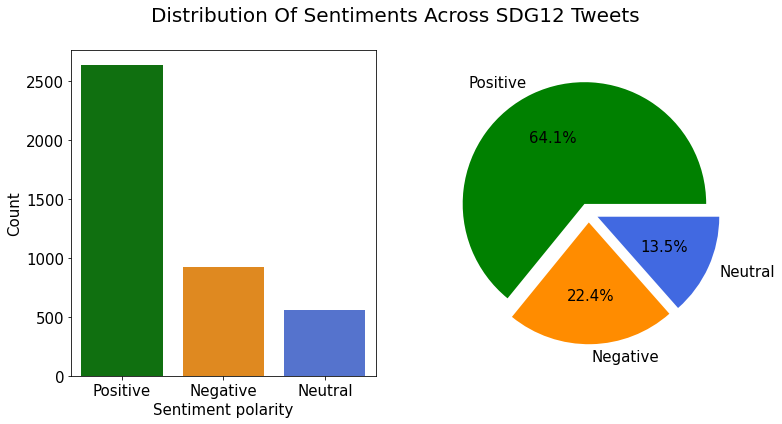

In [106]:
fig, ax = plt.subplots(1,2)

order = ['Positive', 'Negative', 'Neutral']
colors = {'Positive': 'green', 'Negative': 'darkorange', 'Neutral': 'royalblue'}

# bar chart of sentiment polarity - SDG12
sns.countplot(x = 'sentimentPolarity', data = sdg12_dup, ax = ax[0], palette = colors, order = order)
ax[0].tick_params(axis = 'both', labelsize = 15)
ax[0].set_xlabel(xlabel = 'Sentiment polarity', fontsize = 15)
ax[0].set_ylabel(ylabel = 'Count', fontsize = 15)

# pie chart of sentiment polarity - SDG12
ax[1].pie(sdg12_polarity, labels = sdg12_polarity.index, 
          explode = [0.08,0.08,0.08], colors = ['green','darkorange','royalblue'],
          textprops = {'fontsize': 15}, autopct = '%1.1f%%')

fig.set_figwidth(12)
fig.set_figheight(6)
fig.suptitle('Distribution Of Sentiments Across SDG12 Tweets', fontsize = 20)
plt.show()

#### Sentiment polarity in BN Tweets

In [58]:
bn_polarity = bn_dup['sentimentPolarity'].value_counts()[:3]
print('Polarity distribution of BN tweets:')
print(bn_polarity)

Polarity distribution of BN tweets:
Positive    479
Neutral     294
Negative    161
Name: sentimentPolarity, dtype: int64


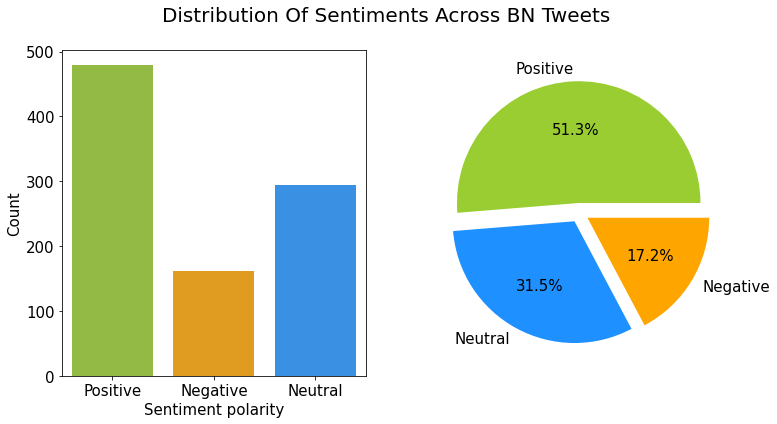

In [107]:
fig, ax = plt.subplots(1,2)

order = ['Positive', 'Negative', 'Neutral']
colors = {'Positive': 'yellowgreen', 'Negative': 'orange', 'Neutral': 'dodgerblue'}

# bar chart of sentiment polarity - BN
sns.countplot(x = 'sentimentPolarity', data = bn_dup, ax = ax[0], palette = colors, order = order)
ax[0].tick_params(axis = 'both', labelsize = 15)
ax[0].set_xlabel(xlabel = 'Sentiment polarity', fontsize = 15)
ax[0].set_ylabel(ylabel = 'Count', fontsize = 15)

# pie chart of sentiment polarity - BN
ax[1].pie(bn_polarity, labels = bn_polarity.index, 
          explode = [0.08,0.08,0.08], colors = ['yellowgreen','dodgerblue','orange'],
         textprops = {'fontsize': 15}, autopct = '%1.1f%%')

fig.set_figwidth(12)
fig.set_figheight(6)
fig.suptitle('Distribution Of Sentiments Across BN Tweets', fontsize = 20)
plt.show()

#### Sentiment score across SDG12 Tweets

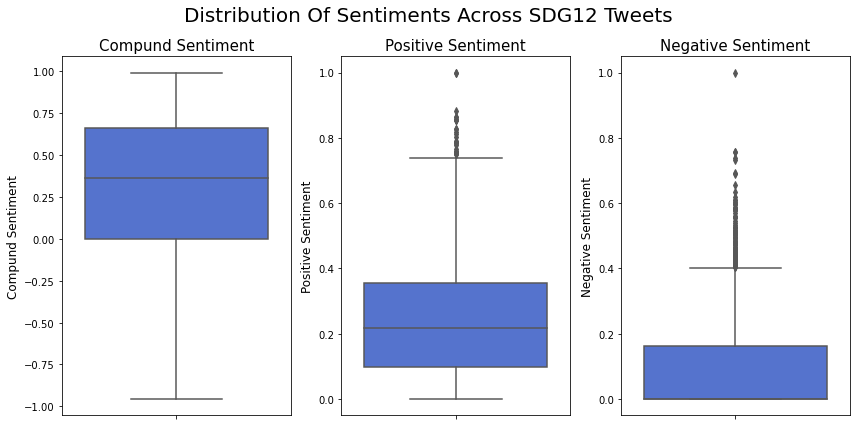

In [108]:
fig, axes = plt.subplots(1, 3, figsize = (12, 6))
fig.suptitle('Distribution Of Sentiments Across SDG12 Tweets', fontsize = 20)

# Plot boxplot 1 - Compound
sns.boxplot(y = 'compoundSentiment', data = sdg12_dup, ax = axes[0], color = 'royalblue')
axes[0].set_title('Compund Sentiment', fontsize = 15)
axes[0].set_ylabel('Compund Sentiment', fontsize = 12)

# Plot boxplot 2 - Positive 
sns.boxplot(y = 'positiveSentiment', data = sdg12_dup, ax = axes[1], color = 'royalblue')
axes[1].set_title('Positive Sentiment', fontsize = 15)
axes[1].set_ylabel('Positive Sentiment', fontsize = 12)

# Plot boxplot 3 - Negative
sns.boxplot(y = 'negativeSentiment', data = sdg12_dup, ax = axes[2], color = 'royalblue')
axes[2].set_title('Negative Sentiment', fontsize = 15)
axes[2].set_ylabel('Negative Sentiment', fontsize = 12)


plt.tight_layout()
plt.show()

#### Sentiment score across BN Tweets

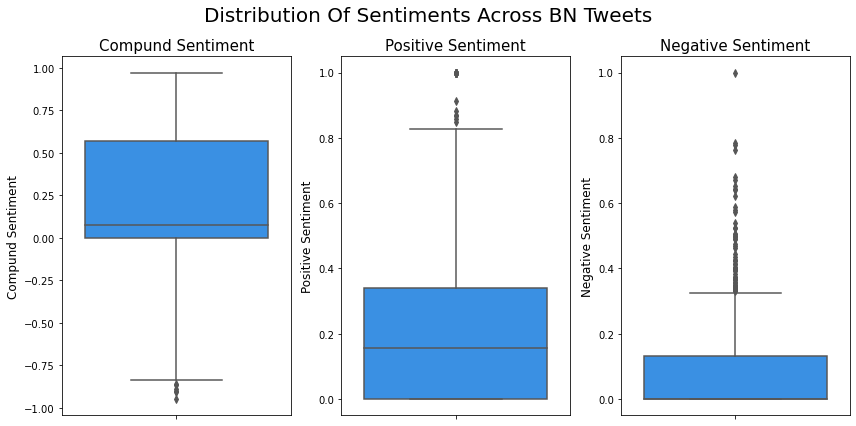

In [109]:
fig, axes = plt.subplots(1, 3, figsize = (12, 6))
fig.suptitle('Distribution Of Sentiments Across BN Tweets', fontsize = 20)

# Plot boxplot 1 - Compound
sns.boxplot(y = 'compoundSentiment', data = bn_dup, ax = axes[0], color = 'dodgerblue')
axes[0].set_title('Compund Sentiment', fontsize = 15)
axes[0].set_ylabel('Compund Sentiment', fontsize = 12)

# Plot boxplot 2 - Positive
sns.boxplot(y = 'positiveSentiment', data = bn_dup, ax = axes[1], color = 'dodgerblue')
axes[1].set_title('Positive Sentiment', fontsize = 15)
axes[1].set_ylabel('Positive Sentiment', fontsize = 12)

# Plot boxplot 3 - Negative
sns.boxplot(y = 'negativeSentiment', data = bn_dup, ax = axes[2], color = 'dodgerblue')
axes[2].set_title('Negative Sentiment', fontsize = 15)
axes[2].set_ylabel('Negative Sentiment', fontsize = 12)


plt.tight_layout()
plt.show()

#### Compound sentiment

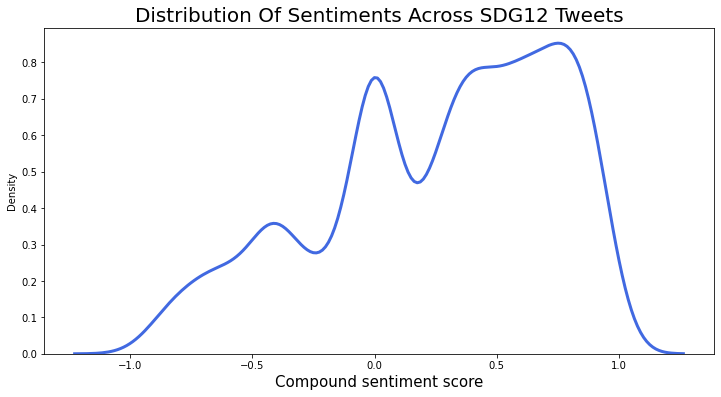

In [110]:
# KDE plot of compound sentiment - SDG12
plt.figure(figsize = (12, 6))
plt.title('Distribution Of Sentiments Across SDG12 Tweets', fontsize = 20)
sns.kdeplot(sdg12_dup['compoundSentiment'], linewidth = 3, color = 'royalblue')
plt.xlabel('Compound sentiment score', fontsize = 15)
plt.show()

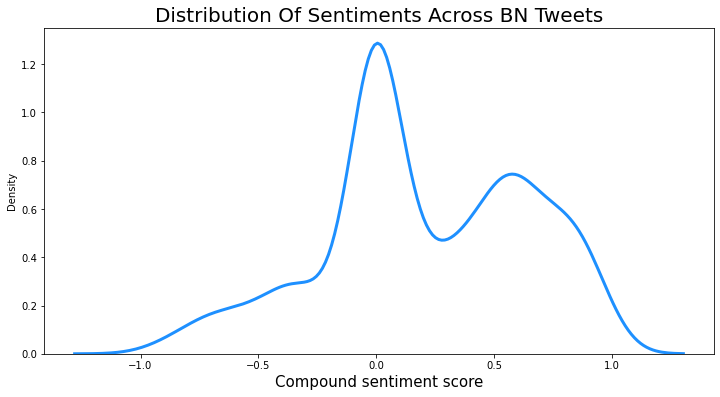

In [111]:
# KDE plot of compound sentiment - BN
plt.figure(figsize = (12, 6))
plt.title('Distribution Of Sentiments Across BN Tweets', fontsize = 20)
sns.kdeplot(bn_dup['compoundSentiment'], linewidth = 3, color = 'dodgerblue')
plt.xlabel('Compound sentiment score', fontsize = 15)
plt.show()

#### Positive sentiment

In [71]:
sdg12_pos = sdg12_dup[sdg12_dup['sentimentPolarity'] == 'Positive']
bn_pos = bn_dup[bn_dup['sentimentPolarity'] == 'Positive']

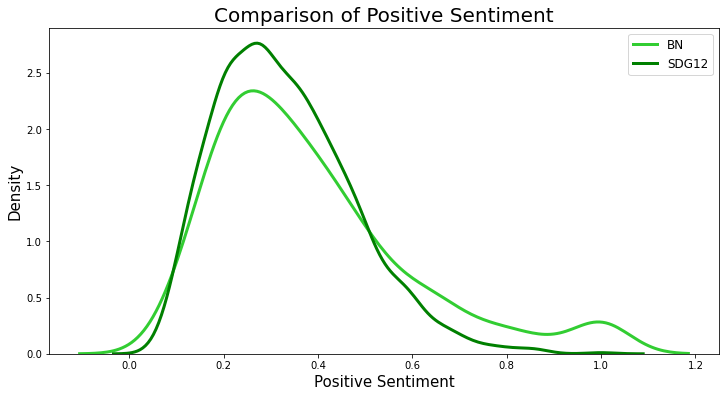

In [128]:
fig, ax = plt.subplots()

# KDE - BN
sns.kdeplot(bn_pos['positiveSentiment'], linewidth = 3, color = 'limegreen', ax = ax)

# KDE - SDG12
sns.kdeplot(sdg12_pos['positiveSentiment'], linewidth = 3, color = 'g', ax = ax)

ax.set_xlabel('Positive Sentiment', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.set_title('Comparison of Positive Sentiment', fontsize = 20)
ax.legend(['BN','SDG12'],fontsize = 'large')

fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

#### Observation: <br>
- Both SDG12 and BN tweets concentrate at low to moderate positivity

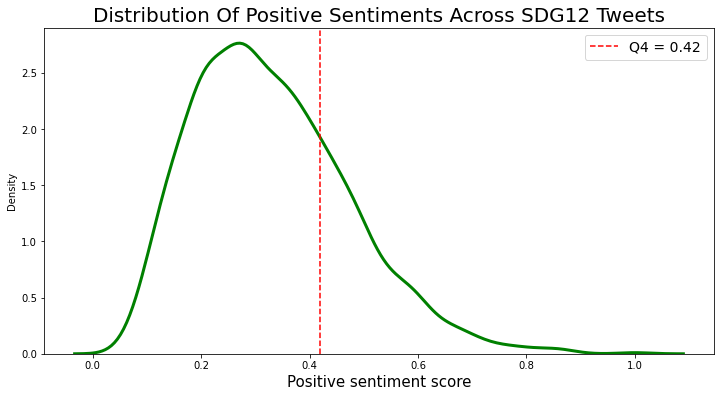

In [113]:
# KDE plot of positive sentiment - SDG12
plt.figure(figsize = (12, 6))
plt.title('Distribution Of Positive Sentiments Across SDG12 Tweets', fontsize = 20)
sns.kdeplot(sdg12_pos['positiveSentiment'], linewidth = 3, color = 'g')
plt.xlabel('Positive sentiment score', fontsize = 15)
q4 = np.percentile(sdg12_pos['positiveSentiment'], 75)
plt.axvline(q4, color = 'red', linestyle = '--', label = 'Q4 = ' + str(q4))
plt.legend(fontsize = 14)
plt.show()

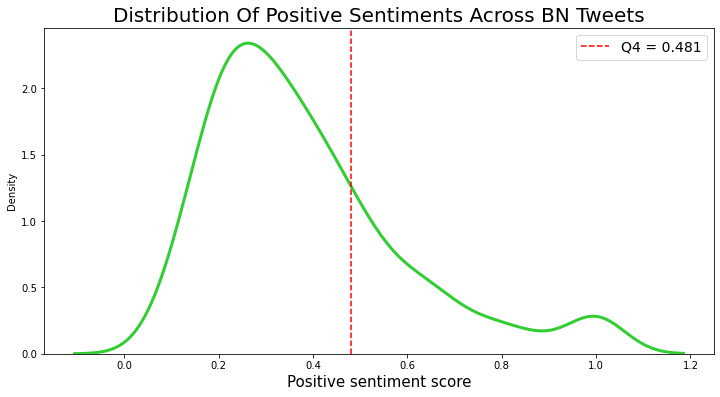

In [114]:
# KDE plot of positive sentiment - BN
plt.figure(figsize = (12, 6))
plt.title('Distribution Of Positive Sentiments Across BN Tweets', fontsize = 20)
sns.kdeplot(bn_pos['positiveSentiment'], linewidth = 3, color = 'limegreen')
plt.xlabel('Positive sentiment score', fontsize = 15)
q4 = np.percentile(bn_pos['positiveSentiment'], 75)
plt.axvline(q4, color = 'red', linestyle = '--', label = 'Q4 = ' + str(q4))
plt.legend(fontsize = 14)
plt.show()

#### Negative sentiment

In [59]:
sdg12_neg = sdg12_dup[sdg12_dup['sentimentPolarity'] == 'Negative']
bn_neg = bn_dup[bn_dup['sentimentPolarity'] == 'Negative']

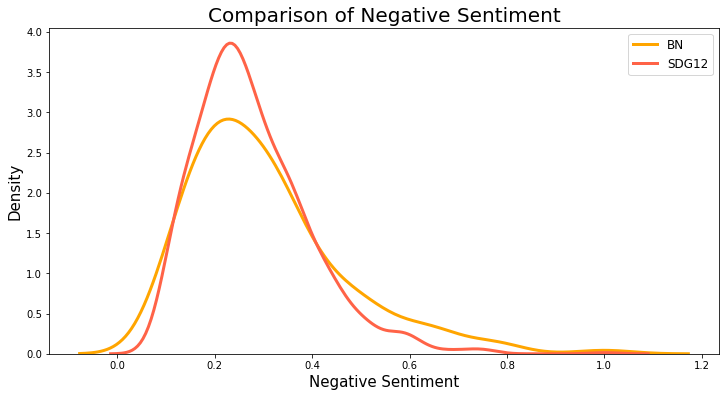

In [129]:
fig, ax = plt.subplots()

# KDE - BN
sns.kdeplot(bn_neg['negativeSentiment'], linewidth = 3, color = 'orange', ax = ax)

# KDE - SDG12
sns.kdeplot(sdg12_neg['negativeSentiment'], linewidth = 3, color = 'tomato', ax = ax)

ax.set_xlabel('Negative Sentiment', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.set_title('Comparison of Negative Sentiment', fontsize = 20)
ax.legend(['BN','SDG12'],fontsize = 'large')

fig.set_figwidth(12)
fig.set_figheight(6)

plt.show()

#### Observation: <br>
- Both SDG12 and BN tweets concentrate at low to moderate negativity

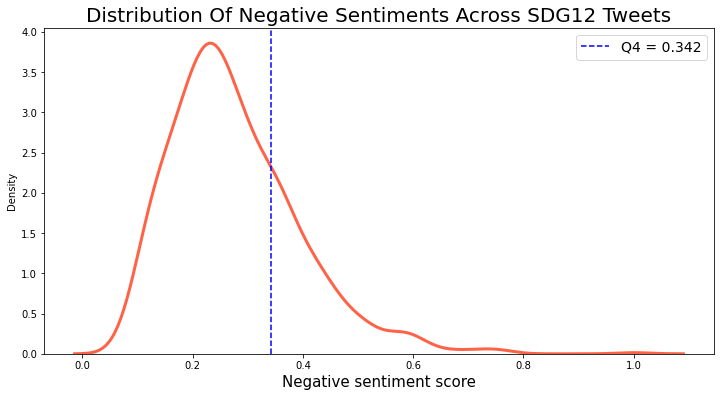

In [116]:
# KDE plot of negative sentiment - SDG12
plt.figure(figsize = (12, 6))
plt.title('Distribution Of Negative Sentiments Across SDG12 Tweets', fontsize = 20)
sns.kdeplot(sdg12_neg['negativeSentiment'], linewidth = 3, color = 'tomato')
plt.xlabel('Negative sentiment score', fontsize = 15)
q4 = np.percentile(sdg12_neg['negativeSentiment'], 75)
plt.axvline(q4, color = 'b', linestyle = '--', label = 'Q4 = ' + str(q4))
plt.legend(fontsize = 14)
plt.show()

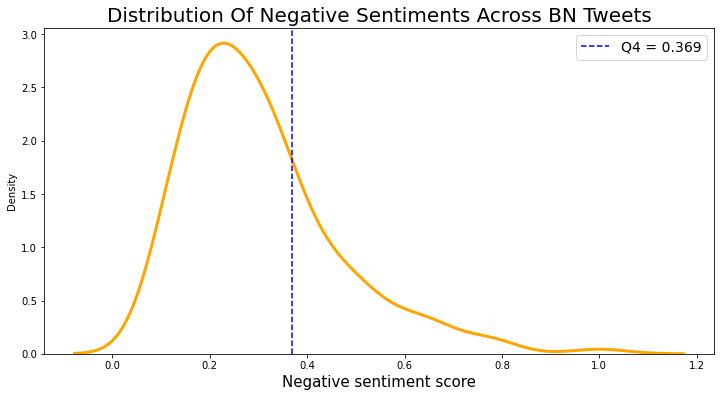

In [117]:
# KDE plot of negative sentiment - BN
plt.figure(figsize = (12, 6))
plt.title('Distribution Of Negative Sentiments Across BN Tweets', fontsize = 20)
sns.kdeplot(bn_neg['negativeSentiment'], linewidth = 3, color = 'orange')
plt.xlabel('Negative sentiment score', fontsize = 15)
q4 = np.percentile(bn_neg['negativeSentiment'], 75)
plt.axvline(q4, color = 'b', linestyle = '--', label = 'Q4 = ' + str(q4))
plt.legend(fontsize = 14)
plt.show()

### 5.2.3 Distribution of sentiments over time

### Proportions of sentiment polarity over time - SDG12

In [60]:
sdg12_polarity_grouped = sdg12_dup.groupby(['yearMonth', 'sentimentPolarity']).size().unstack()

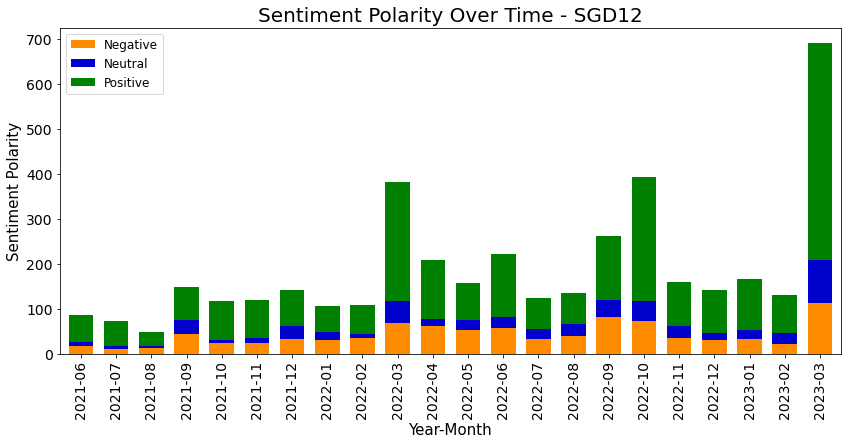

In [131]:
# stacked bar chart of sentiment polarity over time - SDG12
polarity_order = ['Negative', 'Neutral', 'Positive']
colors = {'Positive': 'green', 'Negative': 'darkorange', 'Neutral': 'mediumblue'}

fig, ax = plt.subplots()
sdg12_polarity_grouped.plot(kind ='bar', stacked = True, ax = ax, width = 0.7, align = 'center', color = [colors[sentiment] for sentiment in sdg12_polarity_grouped])

ax.set_xlabel('Year-Month', fontsize = 15)
ax.set_ylabel('Sentiment Polarity', fontsize = 15)
ax.set_title('Sentiment Polarity Over Time - SGD12', fontsize = 20)
plt.xticks(fontsize = 14, rotation = 90, ha = 'center')
plt.yticks(fontsize = 14)
ax.legend(polarity_order, fontsize = 'large')

fig.set_figwidth(14)
fig.set_figheight(6)

plt.show()

In [61]:
sdg12_polarity_grouped['total'] = sdg12_polarity_grouped[['Positive', 'Negative', 'Neutral']].sum(axis=1)

In [62]:
# compute the percentage of each polarity
sdg12_polarity_grouped['pos_percent'] = (sdg12_polarity_grouped['Positive'] / sdg12_polarity_grouped['total'] * 100).round(2)
sdg12_polarity_grouped['neg_percent'] = (sdg12_polarity_grouped['Negative'] / sdg12_polarity_grouped['total'] * 100).round(2)
sdg12_polarity_grouped['neu_percent'] = (sdg12_polarity_grouped['Neutral'] / sdg12_polarity_grouped['total'] * 100).round(2)

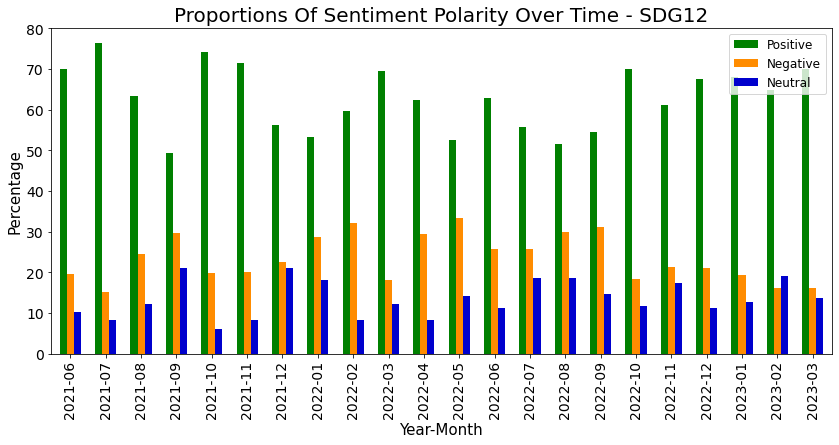

In [134]:
# grouped bar chart of sentiment polarity over time - SDG12
polarity_order = ['Positive', 'Negative', 'Neutral']
colors = ['green', 'darkorange', 'mediumblue']

fig, ax = plt.subplots(figsize=(14, 6))
sdg12_polarity_grouped[['pos_percent', 'neg_percent','neu_percent']].plot(kind='bar', ax=ax, color = colors, width = 0.6)

plt.xlabel('Year-Month', fontsize = 15)
plt.ylabel('Percentage', fontsize = 15)
plt.xticks(fontsize = 14, rotation = 90, ha = 'center')
plt.yticks(fontsize = 14)
ax.legend(polarity_order, fontsize = 'large', loc = 1)
plt.title('Proportions Of Sentiment Polarity Over Time - SDG12', fontsize = 20)

plt.show()

### Proportions of sentiment polarity over time - BN

In [63]:
bn_polarity_grouped = bn_dup.groupby(['yearMonth', 'sentimentPolarity']).size().unstack()

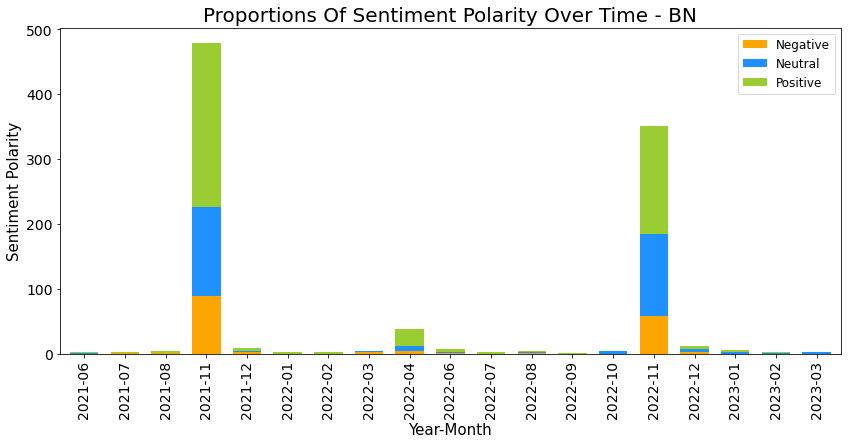

In [136]:
# stacked bar chart of sentiment polarity over time - BN
polarity_order = ['Negative', 'Neutral', 'Positive']
colors = {'Positive': 'yellowgreen', 'Negative': 'orange', 'Neutral': 'dodgerblue'}

fig, ax = plt.subplots()
bn_polarity_grouped.plot(kind ='bar', stacked = True, ax = ax, width = 0.7, align = 'center', color = [colors[sentiment] for sentiment in bn_polarity_grouped])

ax.set_xlabel('Year-Month', fontsize = 15)
ax.set_ylabel('Sentiment Polarity', fontsize = 15)
ax.set_title('Proportions Of Sentiment Polarity Over Time - BN', fontsize = 20)
plt.xticks(fontsize = 14, rotation = 90, ha = 'center')
plt.yticks(fontsize = 14)
ax.legend(polarity_order, fontsize = 'large')

fig.set_figwidth(14)
fig.set_figheight(6)

plt.show()

In [64]:
bn_polarity_grouped['total'] = bn_polarity_grouped[['Positive', 'Negative', 'Neutral']].sum(axis=1)

In [65]:
# compute the percentage of each polarity
bn_polarity_grouped['pos_percent'] = (bn_polarity_grouped['Positive'] / bn_polarity_grouped['total'] * 100).round(2)
bn_polarity_grouped['neg_percent'] = (bn_polarity_grouped['Negative'] / bn_polarity_grouped['total'] * 100).round(2)
bn_polarity_grouped['neu_percent'] = (bn_polarity_grouped['Neutral'] / bn_polarity_grouped['total'] * 100).round(2)

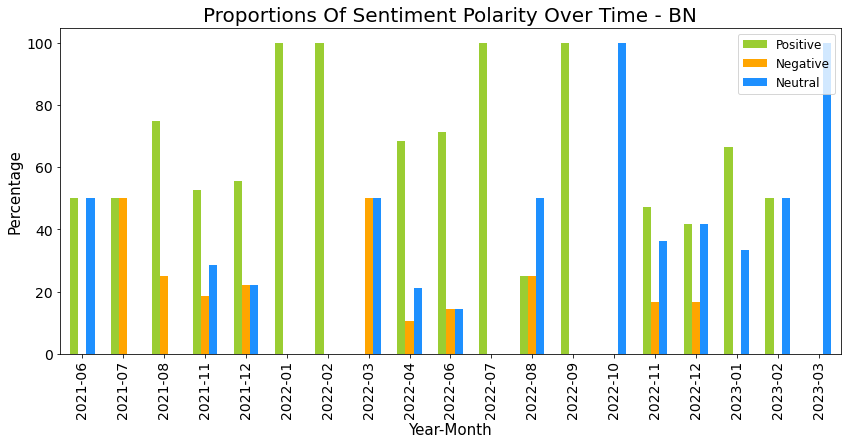

In [139]:
# grouped bar chart of sentiment polarity over time - SDG12
polarity_order = ['Positive', 'Negative', 'Neutral']
colors = ['yellowgreen', 'orange', 'dodgerblue']

fig, ax = plt.subplots(figsize=(14, 6))
bn_polarity_grouped[['pos_percent', 'neg_percent','neu_percent']].plot(kind='bar', ax=ax, color = colors, width = 0.6)

plt.xlabel('Year-Month', fontsize = 15)
plt.ylabel('Percentage', fontsize = 15)
plt.xticks(fontsize = 14, rotation = 90, ha = 'center')
plt.yticks(fontsize = 14)
ax.legend(polarity_order, fontsize = 'large', loc = 1)
plt.title('Proportions Of Sentiment Polarity Over Time - BN', fontsize = 20)

plt.show()

### Distribution of sentiment intensity over time

In [66]:
sdg12_dup['year'] = sdg12_dup['date'].dt.to_period('Y')
bn_dup['year'] = bn_dup['date'].dt.to_period('Y')

In [67]:
# construct subset of datasets for each year, each sentiment polarity - SDG12
sdg12_2023 = sdg12_dup[sdg12_dup['year'] == '2023']
sdg12_2022 = sdg12_dup[sdg12_dup['year'] == '2022']
sdg12_2021 = sdg12_dup[sdg12_dup['year'] == '2021']
sdg12_2023pos = sdg12_2023[sdg12_2023['sentimentPolarity'] == 'Positive']
sdg12_2023neg = sdg12_2023[sdg12_2023['sentimentPolarity'] == 'Negative']
sdg12_2022pos = sdg12_2022[sdg12_2022['sentimentPolarity'] == 'Positive']
sdg12_2022neg = sdg12_2022[sdg12_2022['sentimentPolarity'] == 'Negative']
sdg12_2021pos = sdg12_2021[sdg12_2021['sentimentPolarity'] == 'Positive']
sdg12_2021neg = sdg12_2021[sdg12_2021['sentimentPolarity'] == 'Negative']

In [68]:
# construct subset of datasets for each year, each sentiment polarity - BN
bn_2023 = bn_dup[bn_dup['year'] == '2023']
bn_2022 = bn_dup[bn_dup['year'] == '2022']
bn_2021 = bn_dup[bn_dup['year'] == '2021']
bn_2023pos = bn_2023[bn_2023['sentimentPolarity'] == 'Positive']
bn_2023neg = bn_2023[bn_2023['sentimentPolarity'] == 'Negative']
bn_2022pos = bn_2022[bn_2022['sentimentPolarity'] == 'Positive']
bn_2022neg = bn_2022[bn_2022['sentimentPolarity'] == 'Negative']
bn_2021pos = bn_2021[bn_2021['sentimentPolarity'] == 'Positive']
bn_2021neg = bn_2021[bn_2021['sentimentPolarity'] == 'Negative']

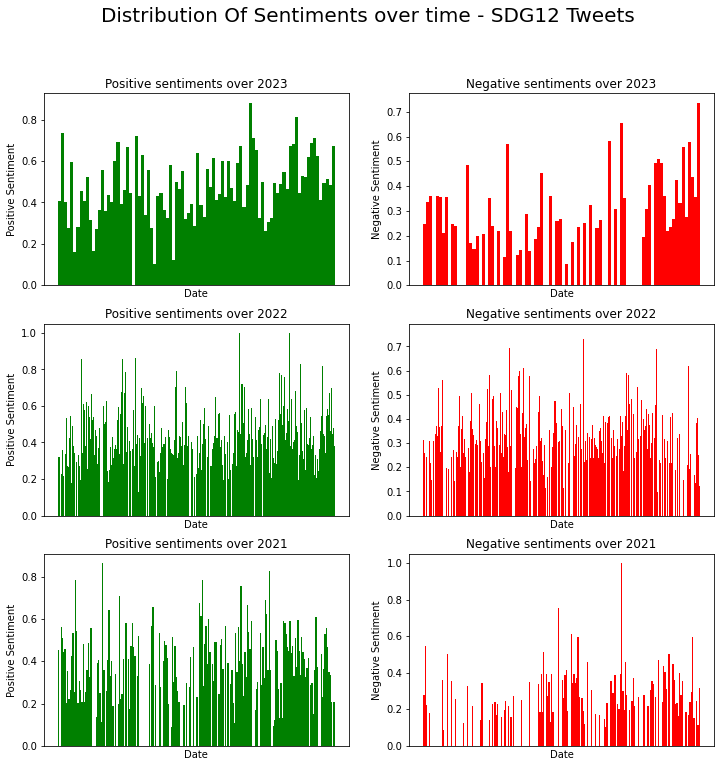

In [69]:
# 3x2 barcharts showing positive and negative sentiment scores across 2021, 2022, 2023 - SDG12
fig, ax = plt.subplots(3,2)

ax[0,0].bar(x = 'date', height = 'positiveSentiment', data = sdg12_2023pos, width = 1.0, color = 'green')
ax[0,1].bar(x = 'date', height = 'negativeSentiment', data = sdg12_2023neg, width = 1.0, color = 'red')
ax[1,0].bar(x = 'date', height = 'positiveSentiment', data = sdg12_2022pos, width = 1.0, color = 'green')
ax[1,1].bar(x = 'date', height = 'negativeSentiment', data = sdg12_2022neg, width = 1.0, color = 'red')
ax[2,0].bar(x = 'date', height = 'positiveSentiment', data = sdg12_2021pos, width = 1.0, color = 'green')
ax[2,1].bar(x = 'date', height = 'negativeSentiment', data = sdg12_2021neg, width = 1.0, color = 'red')

for row in ax:
    for axis in row:
        axis.set_xticks([])
        
ax[0,0].title.set_text('Positive sentiments over 2023')
ax[0,1].title.set_text('Negative sentiments over 2023')
ax[1,0].title.set_text('Positive sentiments over 2022')
ax[1,1].title.set_text('Negative sentiments over 2022')
ax[2,0].title.set_text('Positive sentiments over 2021')
ax[2,1].title.set_text('Negative sentiments over 2021')

for row in ax:
    for axis in row:
        axis.set_xlabel('Date')
        
ax[0, 0].set_ylabel('Positive Sentiment')
ax[0, 1].set_ylabel('Negative Sentiment')
ax[1, 0].set_ylabel('Positive Sentiment')
ax[1, 1].set_ylabel('Negative Sentiment')
ax[2, 0].set_ylabel('Positive Sentiment')
ax[2, 1].set_ylabel('Negative Sentiment')

fig.suptitle('Distribution Of Sentiments over time - SDG12 Tweets', fontsize = 20)
fig.set_figwidth(12)
fig.set_figheight(12)
plt.show()

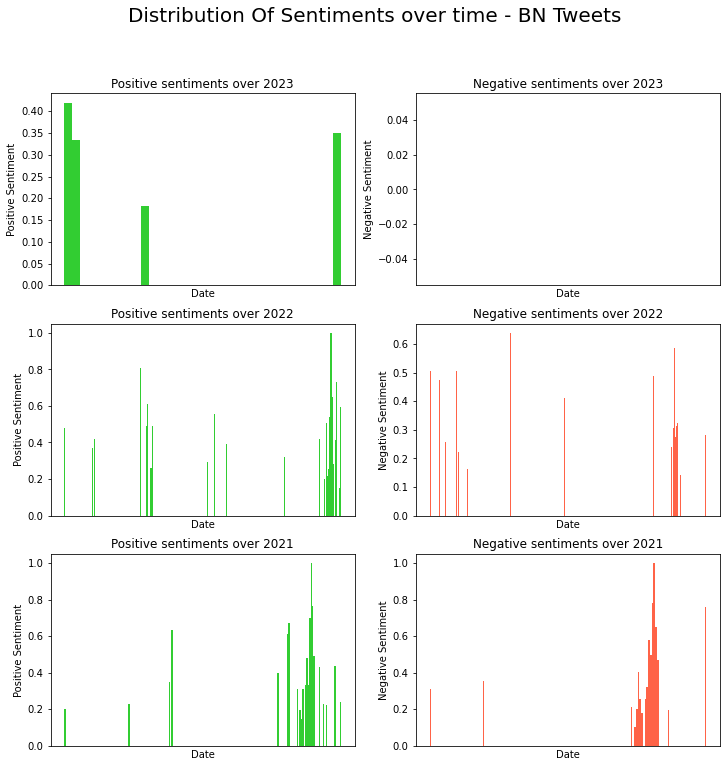

In [95]:
# 3x2 barcharts showing positive and negative sentiment scores across 2021, 2022, 2023 - BN
fig, ax = plt.subplots(3,2)

ax[0,0].bar(x = 'date', height = 'positiveSentiment', data = bn_2023pos, width = 1.0, color = 'limegreen')
ax[0,1].bar(x = 'date', height = 'negativeSentiment', data = bn_2023neg, width = 1.0, color = 'tomato')
ax[1,0].bar(x = 'date', height = 'positiveSentiment', data = bn_2022pos, width = 1.0, color = 'limegreen')
ax[1,1].bar(x = 'date', height = 'negativeSentiment', data = bn_2022neg, width = 1.0, color = 'tomato')
ax[2,0].bar(x = 'date', height = 'positiveSentiment', data = bn_2021pos, width = 1.0, color = 'limegreen')
ax[2,1].bar(x = 'date', height = 'negativeSentiment', data = bn_2021neg, width = 1.0, color = 'tomato')

for row in ax:
    for axis in row:
        axis.set_xticks([])
        
ax[0,0].title.set_text('Positive sentiments over 2023')
ax[0,1].title.set_text('Negative sentiments over 2023')
ax[1,0].title.set_text('Positive sentiments over 2022')
ax[1,1].title.set_text('Negative sentiments over 2022')
ax[2,0].title.set_text('Positive sentiments over 2021')
ax[2,1].title.set_text('Negative sentiments over 2021')

for row in ax:
    for axis in row:
        axis.set_xlabel('Date')
        
ax[0, 0].set_ylabel('Positive Sentiment')
ax[0, 1].set_ylabel('Negative Sentiment')
ax[1, 0].set_ylabel('Positive Sentiment')
ax[1, 1].set_ylabel('Negative Sentiment')
ax[2, 0].set_ylabel('Positive Sentiment')
ax[2, 1].set_ylabel('Negative Sentiment')

fig.suptitle('Distribution Of Sentiments over time - BN Tweets', fontsize = 20)
fig.set_figwidth(12)
fig.set_figheight(12)
plt.show()

### 5.2.4 Sentiment - WordCloud

#### Select top 25% positive and negative tweets

In [72]:
# select tweets with positive / negative score higher than Q4
sdg12_toppos = sdg12_pos[sdg12_pos['positiveSentiment'] >= 0.421]
bn_toppos = bn_pos[bn_pos['positiveSentiment'] >= 0.481]
sdg12_topneg = sdg12_neg[sdg12_neg['negativeSentiment'] >= 0.342]
bn_topneg = bn_neg[bn_neg['negativeSentiment'] >= 0.3705]

### WordCloud of top positive tweets

#### SDG12

In [73]:
sdg12_pos_string = ' '.join(sdg12_toppos['content_cleaned_sa'].str.lower())

In [74]:
# remove single alphabets
sdg12_pos_string = re.sub(r'\b\w\b', '', sdg12_pos_string)

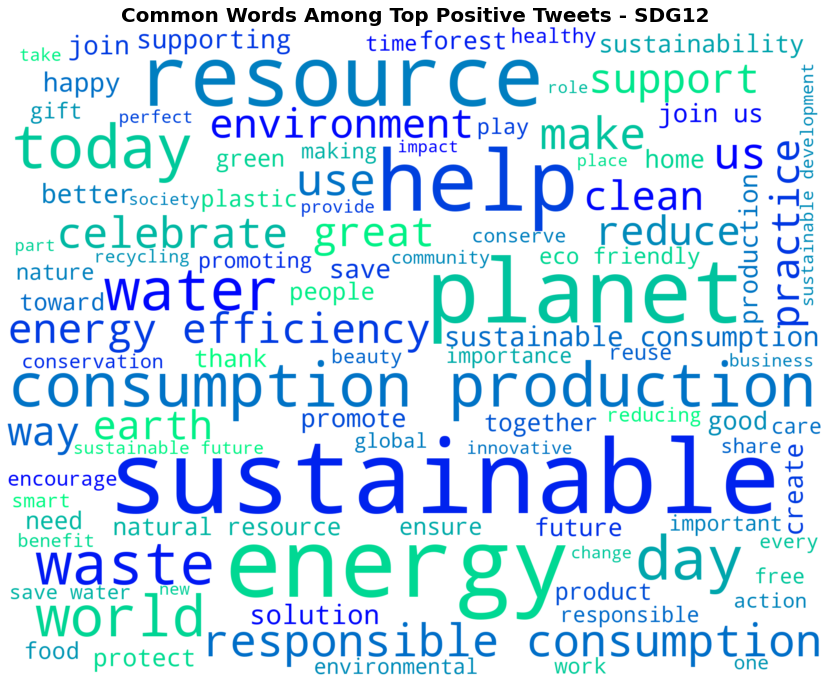

In [143]:
# wordcloud of top positive tweets - SDG12
plt.figure(figsize = (20,12))
sdg12_pos_wordcloud = WordCloud(background_color = 'white', stopwords = STOPWORDS, max_words = 100, 
                            max_font_size = 250, min_font_size = 40, 
                            width = 2000, height = 1600).generate(sdg12_pos_string)
plt.imshow(sdg12_pos_wordcloud.recolor(colormap = 'winter' , random_state = 1), interpolation = 'bilinear')
plt.axis('off')
plt.title('Common Words Among Top Positive Tweets - SDG12', fontsize = 20, fontweight = 'bold')
plt.show()

#### BN

In [75]:
bn_pos_string = ' '.join(bn_toppos['content_cleaned_sa'].str.lower())

In [76]:
# remove single alphabets
bn_pos_string = re.sub(r'\b\w\b', '', bn_pos_string)

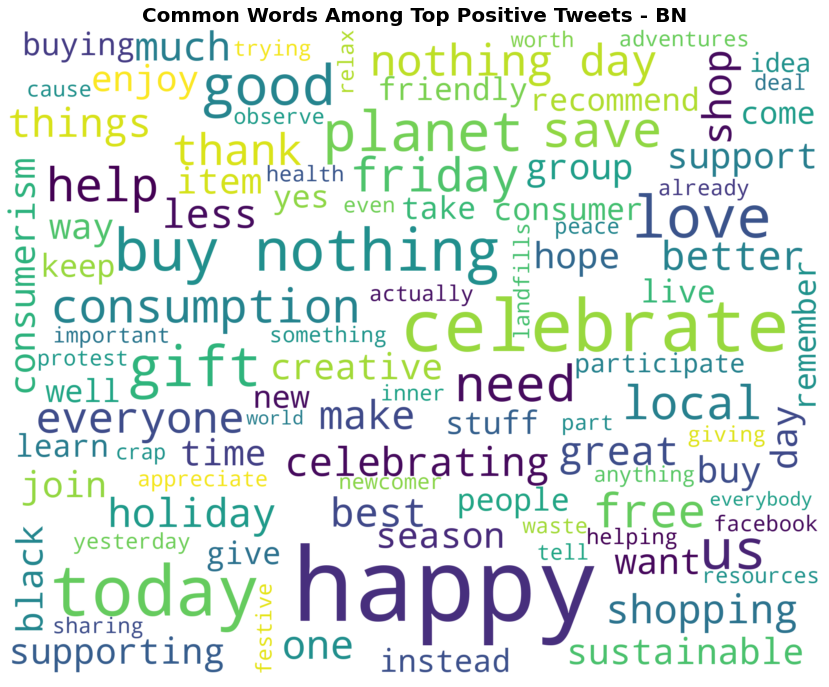

In [112]:
# wordcloud of top positive tweets - BN
plt.figure(figsize = (20,12))
bn_pos_wordcloud = WordCloud(background_color = 'white', stopwords = STOPWORDS, max_words = 100, 
                            max_font_size = 250, min_font_size = 40, 
                            width = 2000, height = 1600).generate(bn_pos_string)
plt.imshow(bn_pos_wordcloud.recolor(colormap = 'viridis' , random_state = 1), interpolation = 'bilinear')
plt.axis('off')
plt.title('Common Words Among Top Positive Tweets - BN', fontsize = 20, fontweight = 'bold')
plt.show()

### WordCloud of top negative tweets

#### SDG12

In [77]:
sdg12_neg_string = ' '.join(sdg12_topneg['content_cleaned_sa'].str.lower())

In [78]:
# remove single alphabets
sdg12_neg_string = re.sub(r'\b\w\b', '', sdg12_neg_string)

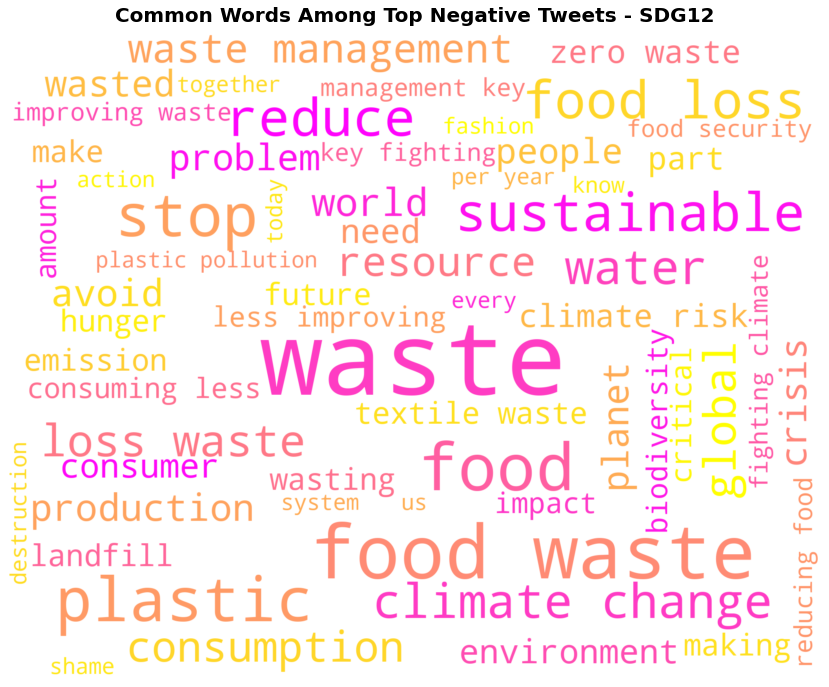

In [115]:
# wordcloud of top negative tweets - SDG12
plt.figure(figsize = (20,12))
sdg12_neg_wordcloud = WordCloud(background_color = 'white', stopwords = STOPWORDS, max_words = 100, 
                            max_font_size = 250, min_font_size = 45, 
                            width = 2000, height = 1600).generate(sdg12_neg_string)
plt.imshow(sdg12_neg_wordcloud.recolor(colormap = 'spring' , random_state = 3), interpolation = 'bilinear')
plt.axis('off')
plt.title('Common Words Among Top Negative Tweets - SDG12', fontsize = 20, fontweight = 'bold')
plt.show()

#### BN

In [79]:
bn_neg_string = ' '.join(bn_topneg['content_cleaned_sa'].str.lower())

In [80]:
# remove single alphabets
bn_neg_string = re.sub(r'\b\w\b', '', bn_neg_string)

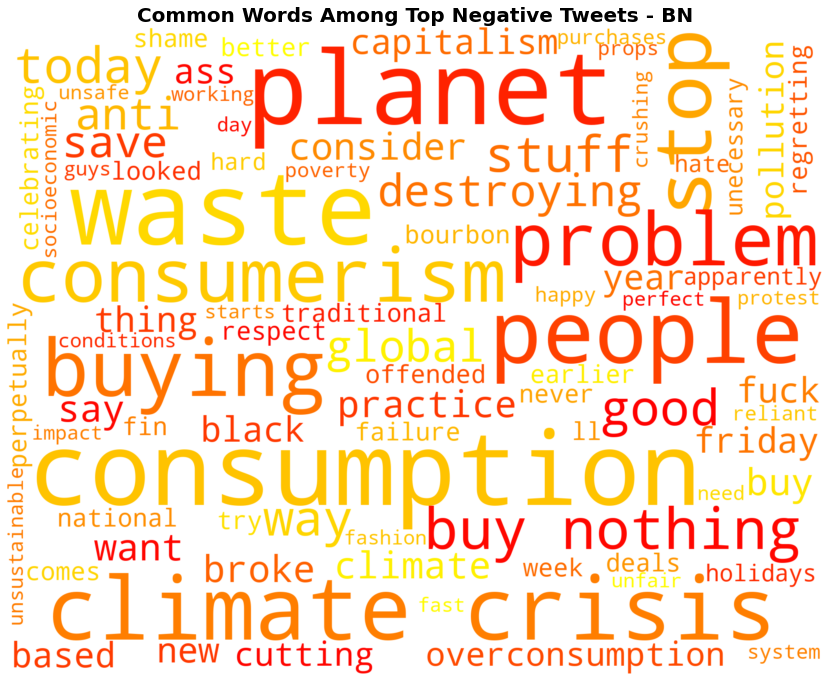

In [118]:
# wordcloud of top negative tweets - BN
plt.figure(figsize = (20,12))
bn_neg_wordcloud = WordCloud(background_color = 'white', stopwords = STOPWORDS, max_words = 100, 
                            max_font_size = 250, min_font_size = 40, 
                            width = 2000, height = 1600).generate(bn_neg_string)
plt.imshow(bn_neg_wordcloud.recolor(colormap = 'autumn' , random_state = 1), interpolation = 'bilinear')
plt.axis('off')
plt.title('Common Words Among Top Negative Tweets - BN', fontsize = 20, fontweight = 'bold')
plt.show()

### 5.2.5 Sentiment - hashtag

### Frequently used hashtags among top positive tweets

#### SDG12

In [81]:
print('Frequently-used hashtags in top positive SDG12 tweets')
sdg12_pos_hashtags = Counter([item for sublist in sdg12_toppos['hashtag'] for item in sublist])
sdg12_pos_hashtags20 = pd.DataFrame(sdg12_pos_hashtags.most_common(20))
sdg12_pos_hashtags20.columns = ['Top positive hashtags', 'Frequency']
sdg12_pos_hashtags20.style.background_gradient(cmap = 'Blues')

Frequently-used hashtags in top positive SDG12 tweets


#### BN

In [82]:
print('Frequently-used hashtags in highly positive BN tweets')
bn_pos_hashtags = Counter([item for sublist in bn_toppos['hashtag'] for item in sublist])
bn_pos_hashtags20 = pd.DataFrame(bn_pos_hashtags.most_common(20))
bn_pos_hashtags20.columns = ['Top positive hashtags', 'Frequency']
bn_pos_hashtags20.style.background_gradient(cmap = 'Purples')

Frequently-used hashtags in highly positive BN tweets


### Frequently used hashtags among top negative tweets

#### SDG12

In [83]:
print('Frequently-used hashtags in highly negative SDG12 tweets')
sdg12_neg_hashtags = Counter([item for sublist in sdg12_topneg['hashtag'] for item in sublist])
sdg12_neg_hashtags20 = pd.DataFrame(sdg12_neg_hashtags.most_common(20))
sdg12_neg_hashtags20.columns = ['Top negative hashtags', 'Frequency']
sdg12_neg_hashtags20.style.background_gradient(cmap = 'Reds')

Frequently-used hashtags in highly negative SDG12 tweets


#### BN

In [84]:
print('Frequently-used hashtags in highly negative BN tweets')
bn_neg_hashtags = Counter([item for sublist in bn_topneg['hashtag'] for item in sublist])
bn_topneg_hashtags20 = pd.DataFrame(bn_neg_hashtags.most_common(20))
bn_topneg_hashtags20.columns = ['Top negative hashtags', 'Frequency']
bn_topneg_hashtags20.style.background_gradient(cmap = 'OrRd')

Frequently-used hashtags in highly negative BN tweets


### 5.2.7 Sentiment wise words

### Frequently used words among top positive tweets

#### SDG12

In [85]:
print('Frequently-used words in highly positive SDG12 tweets')
sdg12_pos_words = Counter([item for sublist in sdg12_toppos['content_cleaned'] for item in sublist])
sdg12_pos_words20 = pd.DataFrame(sdg12_pos_words.most_common(20))
sdg12_pos_words20.columns = ['Top words', 'Frequency']
sdg12_pos_words20.style.background_gradient(cmap = 'Blues')

Frequently-used words in highly positive SDG12 tweets


#### BN

In [86]:
print('Frequently-used words in highly positive BN tweets')
bn_pos_words = Counter([item for sublist in bn_toppos['content_cleaned'] for item in sublist])
bn_pos_words20 = pd.DataFrame(bn_pos_words.most_common(20))
bn_pos_words20.columns = ['Top words', 'Frequency']
bn_pos_words20.style.background_gradient(cmap = 'Purples')

Frequently-used words in highly positive BN tweets


### Frequently used words among top negative tweets

#### SDG12

In [87]:
print('Frequently-used words in highly negative SDG12 tweets')
sdg12_neg_words = Counter([item for sublist in sdg12_topneg['content_cleaned'] for item in sublist])
sdg12_neg_words20 = pd.DataFrame(sdg12_neg_words.most_common(20))
sdg12_neg_words20.columns = ['Top words', 'Frequency']
sdg12_neg_words20.style.background_gradient(cmap = 'Reds')

Frequently-used words in highly negative SDG12 tweets


#### BN

In [88]:
print('Frequently-used words in highly negative BN tweets')
bn_neg_words = Counter([item for sublist in bn_topneg['content_cleaned'] for item in sublist])
bn_neg_words20 = pd.DataFrame(bn_neg_words.most_common(20))
bn_neg_words20.columns = ['Top words', 'Frequency']
bn_neg_words20.style.background_gradient(cmap = 'OrRd')

Frequently-used words in highly negative BN tweets


# 6. Topic modeling

### 6.1 Data preparation for topic modeling

### 6.1.1 POS tagging & text processing

In [89]:
# classify words into noun, verb, adjective, adverb
def get_pos_tag(tag):
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.ADV

### 6.1.2 Text processing

In [90]:
lemmatizer = WordNetLemmatizer()
def lemmatization_lda(text):
    pos_tags = nltk.pos_tag(text)
    lemma = [lemmatizer.lemmatize(text, 
                                  pos = get_pos_tag(tag)) for text, tag in pos_tags]
    lemma = [text for text in lemma if text not in sw]
    return lemma

### 6.1.3 Data selection

In [91]:
# select only noun and adjective (more meaningful words)
def get_noun_adj(text):
    
    pos_tags = nltk.pos_tag(text)
    noun_adj = [word for (word, tag) in pos_tags if (tag == "NN" or tag == "NNS" 
                                                         or tag == "JJ" or tag == "JJR" or tag == "JJS")] 
    return noun_adj

In [92]:
# text processing - SDG Tweets
sdg12_dup['content_cleaned_lda'] = sdg12_dup['content'].apply(lambda x: text_cleaning(x))
sdg12_dup['content_cleaned_lda'] = sdg12_dup['content_cleaned_lda'].apply(lambda x: tokenization(x))
sdg12_dup['content_cleaned_lda'] = sdg12_dup['content_cleaned_lda'].apply(lambda x: lemmatization_lda(x))
sdg12_dup['noun_adj'] = sdg12_dup['content_cleaned_lda'].apply(lambda x: get_noun_adj(x))

In [93]:
# text processing - BN Tweets
bn_dup['content_cleaned_lda'] = bn_dup['content'].apply(lambda x: text_cleaning(x))
bn_dup['content_cleaned_lda'] = bn_dup['content_cleaned_lda'].apply(lambda x: tokenization(x))
bn_dup['content_cleaned_lda'] = bn_dup['content_cleaned_lda'].apply(lambda x: lemmatization_lda(x))
bn_dup['noun_adj'] = bn_dup['content_cleaned_lda'].apply(lambda x: get_noun_adj(x))

In [165]:
sdg12_dup.head()

date                                            content  \
0 2023-03-31  âWaste is only a waste, if we waste itâ A ...   
1 2023-03-31  Heute ist der! Hast du dir schon mal ÃÂ¼berle...   
2 2023-03-31  @UNDPasiapac Well done on the Asia Pacific For...   
3 2023-03-31  It is this time again in the year! The Asia-Pa...   
4 2023-03-31   40% of food crops are lost through pests and ...   

               username  likeCount likeCountGroup  \
0                Prachi          0              0   
1             grek_0523          1         1 to 5   
2            Rebecc1994          4         1 to 5   
3       TheInstitution9         14       11 to 20   
4  guardianesdelpaosaje          0              0   

                                             hashtag yearMonth  date_trunc  \
0  [#saynotoconsumerism, #sustainable, #sdg, #sdg...   2023-03  2023-03-31   
1  [#konsumverhalten, #anticonsumerism, #buyless,...   2023-03  2023-03-31   
2                    [#globalaction, #sdg12, #sdg13]   2023-03  2023-03-31   
3       [#sdg, #sdg6, #sdg9, #sdg12, #sdg13, #apfsd]   2023-03  2023-03-31   
4                       [#sdg12, #foodwastage, #scp]   2023-03  2023-03-31   

                                     content_cleaned  \
0  [waste, waste, waste, beautiful, collage, reus...   
1  [heute, ist, der, hast, du, dir, schon, mal, b...   
2  [well, done, asia, pacific, forum, sustainable...   
3  [time, year, asiapacific, forum, sustainable, ...   
4  [food, crop, lost, pest, plant, disease, food,...   

                                  content_cleaned_sa  compoundSentiment  \
0  âWaste waste , waste itâ beautiful collage...            -0.5423   
1  Heute ist der ! Hast du dir schon mal ÃÂ¼berl...             0.0000   
2  Well done Asia Pacific Forum Sustainable Devel...             0.2732   
3  time year ! Asia-Pacific Forum Sustainable Dev...             0.7906   
4  food crops lost pests plant diseases . Food wa...            -0.6705   

   positiveSentiment  negativeSentiment  neutralSentiment sentimentPolarity  \
0              0.167              0.361             0.472          Negative   
1              0.000              0.000             1.000           Neutral   
2              0.259              0.000             0.741          Positive   
3              0.194              0.000             0.806          Positive   
4              0.082              0.278             0.641          Negative   

                                 content_cleaned_lda  \
0  [waste, waste, waste, beautiful, collage, reus...   
1  [heute, ist, der, hast, du, dir, schon, mal, b...   
2  [well, asia, pacific, forum, sustainable, deve...   
3  [time, year, asiapacific, forum, sustainable, ...   
4  [food, crop, lose, pest, plant, disease, food,...   

                                            noun_adj  
0  [waste, waste, waste, beautiful, collage, reus...  
1  [heute, ist, der, hast, du, dir, schon, mal, b...  
2         [pacific, forum, sustainable, development]  
3  [time, year, sustainable, development, apfsd, ...  
4  [food, crop, pest, plant, disease, food, waste...

### 6.1.4 Construct bigrams

In [94]:
# transform each tweet into a list of tokens
sdg12_corpus = list(sdg12_dup['noun_adj'] )
bn_corpus = list(bn_dup['noun_adj'] )

In [95]:
# learn bigrams in tweets
sdg12_phrases = gensim.models.Phrases(sdg12_corpus, min_count = 10, threshold = 20)
# create a bigram model with the learned bigrams
sdg12_bigram_model = gensim.models.phrases.Phraser(sdg12_phrases)

In [96]:
# learn bigrams in tweets
bn_phrases = gensim.models.Phrases(bn_corpus, min_count = 10, threshold = 20)
# create a bigram model with the learned bigrams
bn_bigram_model = gensim.models.phrases.Phraser(bn_phrases)

In [97]:
def construct_bigrams(corpus, bigram_model):
    bigrams = [bigram_model[tweet] for tweet in corpus]
    return bigrams

#### SDG12 bigrams

In [98]:
sdg12_bigrams = construct_bigrams(sdg12_corpus, sdg12_bigram_model)

In [99]:
bigram_counter = Counter()

In [100]:
print('Common bigrams in SDG12 tweets')
bigram_counter = Counter()

for key in sdg12_phrases.vocab.keys():
    if len(str(key).split('_')) > 1:
        bigram_counter[key] += sdg12_phrases.vocab[key]

sdg12_bigrams_df = pd.DataFrame(bigram_counter.most_common(100))
sdg12_bigrams_df.columns = ['Bigrams', 'Frequency']
sdg12_bigrams_df.style.background_gradient(cmap = 'Blues')

Common bigrams in SDG12 tweets


#### BN bigrams

In [101]:
bn_bigrams = construct_bigrams(bn_corpus, bn_bigram_model)

In [102]:
print('Common bigrams in BN tweets')
bigram_counter = Counter()

for key in bn_phrases.vocab.keys():
    if len(str(key).split('_')) > 1:
        bigram_counter[key] += bn_phrases.vocab[key]

bn_bigrams_df = pd.DataFrame(bigram_counter.most_common(30))
bn_bigrams_df.columns = ['Bigrams', 'Frequency']
bn_bigrams_df.style.background_gradient(cmap = 'Purples')

Common bigrams in BN tweets


### 6.1.5 Word2Vec

#### Feed the bigrams to train the Word2Vec model

#### W2V bigrams - SDG12

In [103]:
sdg12_w2vmodel = Word2Vec(sdg12_bigram_model[sdg12_corpus], seed = 1)

In [104]:
print('Common bigrams in SDG12 tweets - W2V model')

bigram_counter = Counter()

for key in sdg12_w2vmodel.wv.key_to_index.keys():
    if len(str(key).split("_")) > 1:
        bigram_counter[key] += sdg12_w2vmodel.wv.get_vecattr(key, 'count')

sdg12_w2v_bigrams_df = pd.DataFrame(bigram_counter.most_common(30))
sdg12_w2v_bigrams_df.columns = ['Bigrams', 'Frequency']
sdg12_w2v_bigrams_df.style.background_gradient(cmap = 'Blues')

Common bigrams in SDG12 tweets - W2V model


In [108]:
# A query to find positively-correlated words for any word - SDG12
sdg12_w2vmodel.wv.most_similar(positive = ['consumption'])

[('production', 0.9993274211883545),
 ('practice', 0.9992005825042725),
 ('responsible', 0.999192476272583),
 ('pattern', 0.9990636706352234),
 ('sustainable', 0.9989689588546753),
 ('promote', 0.9989153146743774),
 ('choice', 0.9988577961921692),
 ('sdg', 0.9988503456115723),
 ('development_goal', 0.9988407492637634),
 ('support', 0.9988130927085876)]

#### W2V bigrams - BN

In [109]:
bn_w2vmodel = Word2Vec(bn_bigram_model[bn_corpus], seed = 1)

In [110]:
print('Common bigrams in BN tweets - W2V model')

bigram_counter = Counter()

for key in bn_w2vmodel.wv.key_to_index.keys():
    if len(str(key).split("_")) > 1:
        bigram_counter[key] += bn_w2vmodel.wv.get_vecattr(key, 'count')

bn_w2v_bigrams_df = pd.DataFrame(bigram_counter.most_common(20))
bn_w2v_bigrams_df.columns = ['Bigrams', 'Frequency']
bn_w2v_bigrams_df.style.background_gradient(cmap = 'Purples')

Common bigrams in BN tweets - W2V model


In [112]:
# A query to find positively-correlated words for any word - BN
bn_w2vmodel.wv.most_similar(positive = ['black'], topn = 20)

[('consume', 0.6746981143951416),
 ('open', 0.6616785526275635),
 ('way', 0.6501327753067017),
 ('future', 0.6402317881584167),
 ('anything', 0.63982093334198),
 ('much', 0.639220118522644),
 ('black_friday', 0.6351172924041748),
 ('pollution', 0.6328985095024109),
 ('help', 0.6324412822723389),
 ('start', 0.6308441758155823),
 ('day', 0.6303244233131409),
 ('impact', 0.6290578246116638),
 ('gift', 0.6278504133224487),
 ('encourage', 0.6278305649757385),
 ('part', 0.626893162727356),
 ('product', 0.6245200037956238),
 ('attention', 0.62106853723526),
 ('create', 0.6195849180221558),
 ('packaging', 0.6195647716522217),
 ('environment', 0.6188020706176758)]

### 6.1.6 BOW

In [113]:
sdg12_dictionary = Dictionary(sdg12_bigrams)

# Filter words that occur less than 20 documents, or more than 70% of the documents.
sdg12_dictionary.filter_extremes(no_below = 20, no_above = 0.7)
sdg12_bow = [sdg12_dictionary.doc2bow(tweet) for tweet in sdg12_corpus]

print('Number of unique tokens: %d' % len(sdg12_dictionary))
print('Number of documents: %d' % len(sdg12_bow))

Number of unique tokens: 429
Number of documents: 4114


In [114]:
bn_dictionary = Dictionary(bn_bigrams)

# Filter words that occur less than 20 documents, or more than 70% of the documents.
bn_dictionary.filter_extremes(no_below = 20, no_above = 0.7)
bn_bow = [bn_dictionary.doc2bow(tweet) for tweet in bn_corpus]

print('Number of unique tokens: %d' % len(bn_dictionary))
print('Number of documents: %d' % len(bn_bow))

Number of unique tokens: 54
Number of documents: 934


### 6.2 LDA model

### 6.2.1 SDG12: Building LDA models

#### LDA model - SDG12

#### SDG12 First model, num_topics = 3

In [115]:
# takes 5 - 10 mins to run
t0 = time.time()

np.random.seed(1) 

sdg12_ldamodel = LdaMulticore(sdg12_bow, 
                    id2word = sdg12_dictionary, 
                    num_topics = 3, 
                    chunksize = 4000, 
                    batch = True,
                    minimum_probability = 0.01,
                    iterations = 300, 
                    passes = 100)                

t1 = time.time()
print("time for 200 passes: ",(t1-t0)," seconds")

time for 200 passes:  335.06687092781067  seconds


In [119]:
# sdg12: 3 topics
sdg12_ldamodel.show_topics(num_words = 10, formatted = False)

[(0,
  [('waste', 0.11643428),
   ('food', 0.08006093),
   ('plastic', 0.041660007),
   ('recycle', 0.02627549),
   ('use', 0.020030962),
   ('reuse', 0.018170431),
   ('year', 0.01632711),
   ('pollution', 0.011489562),
   ('day', 0.010988953),
   ('new', 0.010698599)]),
 (1,
  [('sustainable', 0.09848412),
   ('consumption', 0.0681981),
   ('production', 0.049778946),
   ('responsible', 0.029192692),
   ('resource', 0.018904367),
   ('future', 0.018673873),
   ('sustainability', 0.016091526),
   ('action', 0.0149975475),
   ('consumer', 0.014812252),
   ('planet', 0.0142724905)]),
 (2,
  [('water', 0.052624058),
   ('energy', 0.03799933),
   ('climate', 0.031737413),
   ('economy', 0.024121268),
   ('resource', 0.022736438),
   ('change', 0.020138593),
   ('circular', 0.019064335),
   ('emission', 0.016712336),
   ('use', 0.016534215),
   ('hour', 0.016105447)])]

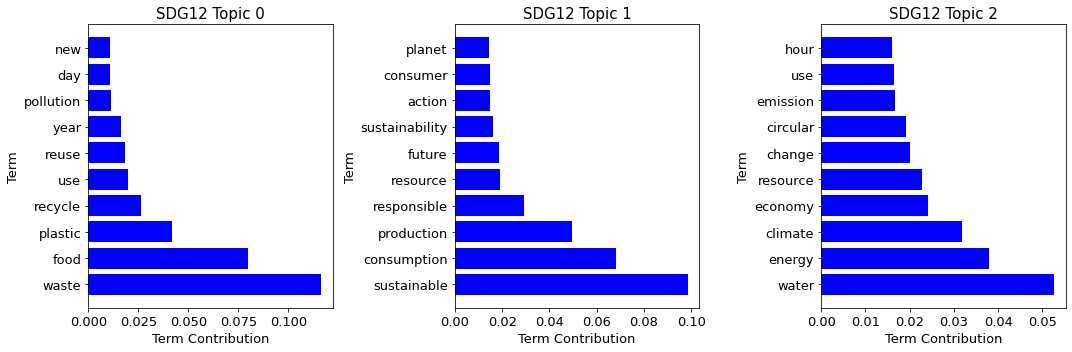

In [187]:
# term contribution - SDG12
sdg12_topic_words = sdg12_ldamodel.show_topics(num_words=10, formatted=False)

terms = []
term_contributions = []
for topic, word_contribs in sdg12_topic_words:
    topic_terms = [word for word, _ in word_contribs]
    term_contrib = [contribution for _, contribution in word_contribs]
    terms.append(topic_terms)
    term_contributions.append(term_contrib)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# horizontal bar chart 
for i, ax in enumerate(axes):
    ax.barh(terms[i], term_contributions[i], color='blue')
    ax.set_title('SDG12 Topic ' + str(i), fontsize = 15)
    ax.set_xlabel('Term Contribution', fontsize = 13)
    ax.set_ylabel('Term', fontsize = 13)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)

plt.tight_layout()

plt.show()

Topics: <br>
- 0: Consumer level: problems and actions
- 1: General discussion about a scp and its impact to the macroenvironment
- 2: Special celebrations related to sustainability and responsible consumption 

#### SDG12 Second model, num_topics = 4

In [116]:
# takes 5 - 10 mins to run
t0 = time.time()

np.random.seed(1) 

sdg12_ldamodel2 = LdaMulticore(sdg12_bow, 
                    id2word = sdg12_dictionary, 
                    num_topics = 4, 
                    chunksize = 4000, 
                    batch = True,
                    minimum_probability = 0.01,
                    iterations = 300, 
                    passes = 100)  

t1 = time.time()
print("time for 200 passes: ",(t1-t0)," seconds")

time for 200 passes:  158.06676054000854  seconds


In [158]:
# sdg12: 4 topics
sdg12_ldamodel2.show_topics(num_words=10, formatted=False)

[(0,
  [('waste', 0.1410928),
   ('food', 0.097266346),
   ('plastic', 0.05052348),
   ('recycle', 0.028605592),
   ('reuse', 0.022043498),
   ('use', 0.015631905),
   ('year', 0.014269005),
   ('pollution', 0.014015608),
   ('end', 0.011639215),
   ('loss', 0.011314643)]),
 (1,
  [('consumption', 0.098253906),
   ('sustainable', 0.09509065),
   ('production', 0.07014423),
   ('responsible', 0.042170275),
   ('consumer', 0.02275242),
   ('development', 0.018022047),
   ('resource', 0.017685376),
   ('action', 0.01631807),
   ('planet', 0.01532455),
   ('fashion', 0.014553632)]),
 (2,
  [('water', 0.06421858),
   ('energy', 0.027551413),
   ('day', 0.026917338),
   ('climate', 0.026759287),
   ('world', 0.026101712),
   ('change', 0.023738509),
   ('use', 0.023221904),
   ('planet', 0.020926554),
   ('earth', 0.019994803),
   ('hour', 0.019654693)]),
 (3,
  [('sustainable', 0.057968922),
   ('economy', 0.029897587),
   ('circular', 0.023616575),
   ('product', 0.021994377),
   ('resourc

### 6.2.2 SDG12: Model evaluation - model perplexity and coherence score 

#### Coherence & perplexity - SDG12 3 Topics

In [117]:
def get_coherence_score(lda_model, bigram_corpus, dictionary, bow):
    coherence_model_lda = CoherenceModel(model = lda_model, texts = bigram_corpus, dictionary = dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    print('\nPerplexity: ', lda_model.log_perplexity(bow))

In [398]:
# sdg12: 3 topics
get_coherence_score(sdg12_ldamodel,sdg12_bigrams,sdg12_dictionary,sdg12_bow)


Coherence Score:  0.34315332398744774

Perplexity:  -5.45989305469019


#### Intertopic distance map - SDG12 3 Topics

In [118]:
# sdg12: 3 topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model = sdg12_ldamodel, corpus = sdg12_bow, dictionary = sdg12_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.121553  0.196987       1        1  39.189214
0     -0.262259 -0.009362       2        1  31.929994
2      0.140706 -0.187624       3        1  28.880792, topic_info=            Term         Freq        Total Category  logprob  loglift
4          waste  1246.000000  1246.000000  Default  30.0000  30.0000
3    sustainable  1310.000000  1310.000000  Default  29.0000  29.0000
22          food   856.000000   856.000000  Default  28.0000  28.0000
20   consumption   895.000000   895.000000  Default  27.0000  27.0000
37         water   509.000000   509.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
48        planet    86.522895   306.641757   Topic3  -4.7161  -0.0233
152     solution    72.346342   169.491067   Topic3  -4.8950   0.3907
93        people    71.813103   183.062566   Topic3  -4.9024   0.3062
209       future    73.550093   318.863196   Topic3  -4.8785  -0.2248
38           day    70.466675   295.003523   Topic3  -4.9213  -0.1899

[185 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7         1  0.972845  achieve
7         3  0.024321  achieve
29        1  0.755815   action
29        2  0.049876   action
29        3  0.195668   action
...     ...       ...      ...
186       3  0.195919     work
101       1  0.337349    world
101       2  0.185697    world
101       3  0.476621    world
19        2  0.992989     year

[238 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

#### Coherence & perplexity - SDG12 4 Topics

In [159]:
# sdg12: 4 topics
get_coherence_score(sdg12_ldamodel2,sdg12_bigrams,sdg12_dictionary,sdg12_bow)


Coherence Score:  0.3783482138692722

Perplexity:  -5.468392272631946


#### Intertopic distance map - SDG12 4 Topics

In [120]:
# sdg12: 4 topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model = sdg12_ldamodel2, corpus=sdg12_bow,dictionary= sdg12_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.157778 -0.023982       1        1  30.546956
0      0.272483 -0.110640       2        1  24.668427
3     -0.149299 -0.118038       3        1  23.151804
2      0.034595  0.252660       4        1  21.632813, topic_info=            Term         Freq        Total Category  logprob  loglift
4          waste  1248.000000  1248.000000  Default  30.0000  30.0000
22          food   857.000000   857.000000  Default  29.0000  29.0000
20   consumption   895.000000   895.000000  Default  28.0000  28.0000
3    sustainable  1315.000000  1315.000000  Default  27.0000  27.0000
37         water   507.000000   507.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
93        people    59.538974   182.956753   Topic4  -4.8009   0.4083
73          help    61.013155   212.673712   Topic4  -4.7764   0.2823
129         join    55.985413   161.393109   Topic4  -4.8624   0.4722
12        global    54.617848   222.864875   Topic4  -4.8871   0.1248
343     emission    52.362759   160.643037   Topic4  -4.9293   0.4100

[242 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
29        1  0.562439  action
29        2  0.011478  action
29        3  0.133914  action
29        4  0.294611  action
273       4  0.977530     air
...     ...       ...     ...
101       2  0.123654   world
101       3  0.108197   world
101       4  0.568807   world
19        2  0.743994    year
19        4  0.249891    year

[350 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])

### 6.2.3 SDG12: Interpretation and analysis

### Proportions of topics - SDG12

#### Compute the major topic and topic contribution across Tweets

In [121]:
sdg12_all_topics = sdg12_ldamodel.get_document_topics(sdg12_bow)

all_topics_csr = gensim.matutils.corpus2csc(sdg12_all_topics)

#topic ids and respective probability
all_topics_numpy = all_topics_csr.T.toarray() 

#select topic id with max probability
major_topic= [np.argmax(arr) for arr in all_topics_numpy] 
topic_contribution = [arr[idx] for arr, idx in zip(all_topics_numpy, major_topic)]

sdg12_dup['lda_topic'] = major_topic
sdg12_dup['topic_contribution'] = topic_contribution

sdg12_dup['topic_contribution'] = sdg12_dup['topic_contribution'].round(3)

In [123]:
sdg12_topic = sdg12_dup['lda_topic'].value_counts()
print('Topics of SDG12 tweets:')
print(sdg12_topic)

Topics of SDG12 tweets:
1    1520
0    1419
2    1175
Name: lda_topic, dtype: int64


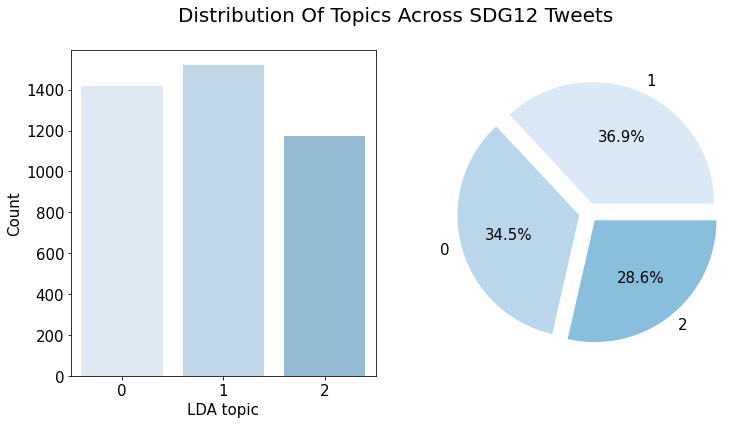

In [124]:
# bar and pie charts of topic distribution - SDG12
fig, ax = plt.subplots(1,2)

colors = sns.color_palette('Blues')

sns.countplot(x = 'lda_topic', data = sdg12_dup, ax=ax[0], palette = colors) 
ax[0].tick_params(axis = 'both', labelsize = 15)


ax[1].pie(sdg12_topic, labels = sdg12_topic.index, 
          explode = [0.08,0.08,0.08], colors = colors,
          textprops = {'fontsize': 15}, autopct = '%1.1f%%')

ax[0].tick_params(axis = 'both', labelsize = 15)
ax[0].set_xlabel('LDA topic', fontsize = 15)
ax[0].set_ylabel('Count', fontsize = 15)

fig.set_figwidth(12)
fig.set_figheight(6)
fig.suptitle('Distribution Of Topics Across SDG12 Tweets', fontsize = 20)
plt.show()

In [125]:
sdg12_topic_grouped = sdg12_dup.groupby(['yearMonth', 'lda_topic']).size().unstack()

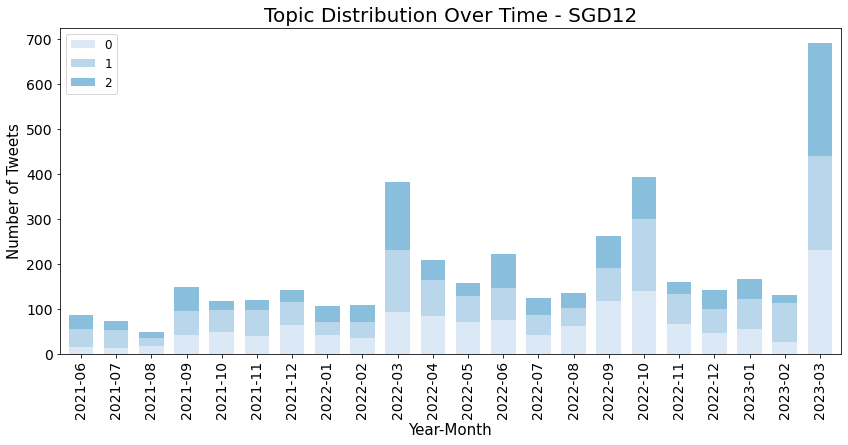

In [191]:
# stacked bar chart of topic distribution acorss year-month - SDG12
colors = sns.color_palette('Blues')

fig, ax = plt.subplots()
sdg12_topic_grouped.plot(kind ='bar', stacked = True, ax = ax, width = 0.7, align = 'center', color = [colors[topic] for topic in sdg12_topic_grouped])

ax.set_xlabel('Year-Month', fontsize = 15)
ax.set_ylabel('Number of Tweets', fontsize = 15)
ax.set_title('Topic Distribution Over Time - SGD12', fontsize = 20)
plt.xticks(fontsize = 14, rotation = 90, ha = 'center')
plt.yticks(fontsize = 14)
ax.legend(fontsize = 'large')

fig.set_figwidth(14)
fig.set_figheight(6)

plt.show()

### Representative Tweets for each topic - SDG12

In [126]:
sdg12_t0 = sdg12_dup[sdg12_dup['lda_topic'] == 0]
sdg12_t1 = sdg12_dup[sdg12_dup['lda_topic'] == 1]
sdg12_t2 = sdg12_dup[sdg12_dup['lda_topic'] == 2]

In [193]:
print('sdg12_topic0')
sdg12_t0['topic_contribution'].describe()

sdg12_topic0


count    1419.000000
mean        0.694853
std         0.161990
min         0.333000
25%         0.568000
50%         0.703000
75%         0.833500
max         0.958000
Name: topic_contribution, dtype: float64

In [194]:
print('sdg12_topic1')
sdg12_t1['topic_contribution'].describe()

sdg12_topic1


count    1519.000000
mean        0.714613
std         0.160132
min         0.336000
25%         0.570000
50%         0.730000
75%         0.865000
max         0.969000
Name: topic_contribution, dtype: float64

In [195]:
print('sdg12_topic2')
sdg12_t2['topic_contribution'].describe()

sdg12_topic2


count    1176.000000
mean        0.687022
std         0.154642
min         0.355000
25%         0.560000
50%         0.667500
75%         0.826250
max         0.962000
Name: topic_contribution, dtype: float64

#### Select the top 25% of each topic

In [127]:
# select tweets with topic contribution higher than Q4
# note: the Q4 figures generated above differ everytime the code is run
sdg12_t0_top = sdg12_t0[sdg12_t0['topic_contribution'] >= 0.845]
sdg12_t1_top = sdg12_t1[sdg12_t1['topic_contribution'] >= 0.85775]
sdg12_t2_top = sdg12_t2[sdg12_t2['topic_contribution'] >= 0.855]

In [128]:
pd.options.display.max_colwidth = 1000

In [202]:
from colorama import Fore

In [398]:
# print the most representative tweets for each topic - SDG12
print(Fore.BLUE + 'Two most representative Tweet for Topic 0 - SDG12:', Fore.RESET)
print(sdg12_t0_top.nlargest(1, 'topic_contribution')['content'].values[0])
print()
print(sdg12_t0_top.nlargest(2, 'topic_contribution')['content'].values[1])
print()
print(Fore.BLUE + 'Two most representative Tweet for Topic 1 - SDG12:', Fore.RESET)
print(sdg12_t1_top.nlargest(1, 'topic_contribution')['content'].values[0])
print()
print(sdg12_t1_top.nlargest(2, 'topic_contribution')['content'].values[1])
print()
print(Fore.BLUE + 'Two most representative Tweet for Topic 2 - SDG12:', Fore.RESET)
print(sdg12_t2_top.nlargest(1, 'topic_contribution')['content'].values[0])
print()
print(sdg12_t2_top.nlargest(2, 'topic_contribution')['content'].values[1])
print()

Two most representative Tweet for Topic 0 - SDG12: 
Food loss & waste isn’t just about perfectly good food not making it to our tables, or the money wasted when it ends up in the bin uneaten. The real cost of lost & wasted food is far greater. Those wasted end up rotting in landfills, giving out greenhouse gases, leading to climate risks instead of feeling millions of people in hunger. #FoodLoss is a shame! #SustainableConsumption #ZeroHunger #SDG12 #SDG2

Have you heard of #plasticfreecoffee? It actually means avoiding plastic coffee pods, filters, and single-use cups when buying your daily cuppa. Instead, opt for #reusable coffee cups and filters. These small changes can significantly reduce the amount of plastic waste that ends up in landfills and oceans. #sustainability #sdg12 #noplastic 

Two most representative Tweet for Topic 1 - SDG12: 
The participant poll says sustainability focuses on buildings and production, I want to bring in the consumer. As consumers, we must be aware t

### Wordcloud for each topic - SDG12

In [129]:
sdg12_t0_string = ' '.join(sdg12_t0['content_cleaned_sa'].str.lower())
sdg12_t0_string = re.sub(r'\b\w\b', '', sdg12_t0_string)

In [130]:
sdg12_t1_string = ' '.join(sdg12_t1['content_cleaned_sa'].str.lower())
sdg12_t1_string = re.sub(r'\b\w\b', '', sdg12_t1_string)

In [131]:
sdg12_t2_string = ' '.join(sdg12_t2['content_cleaned_sa'].str.lower())
sdg12_t2_string = re.sub(r'\b\w\b', '', sdg12_t2_string)

In [132]:
import warnings
warnings.filterwarnings('ignore')

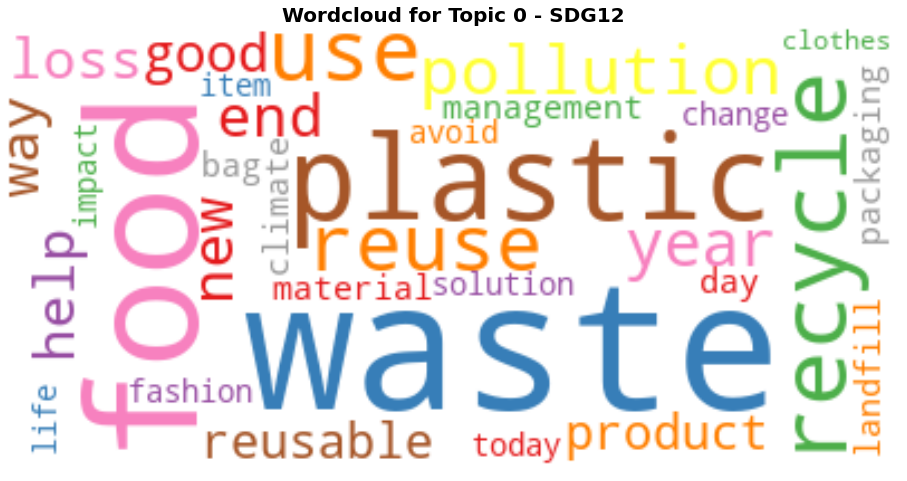

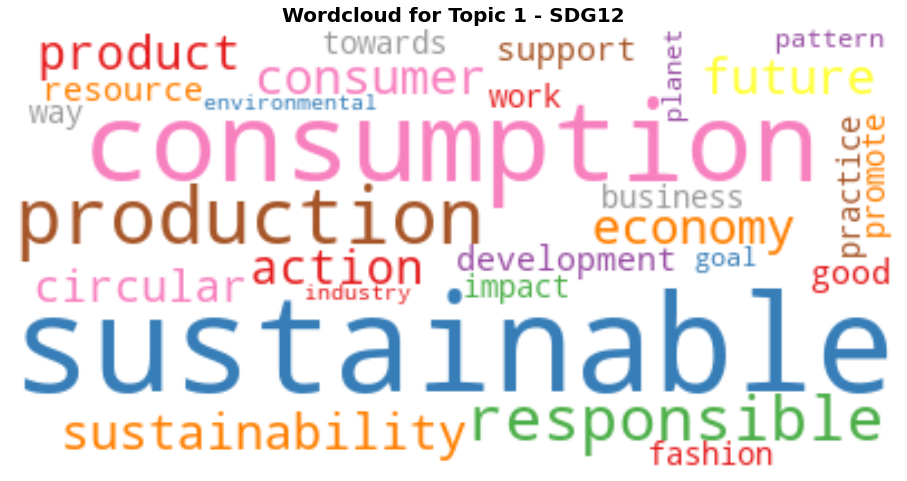

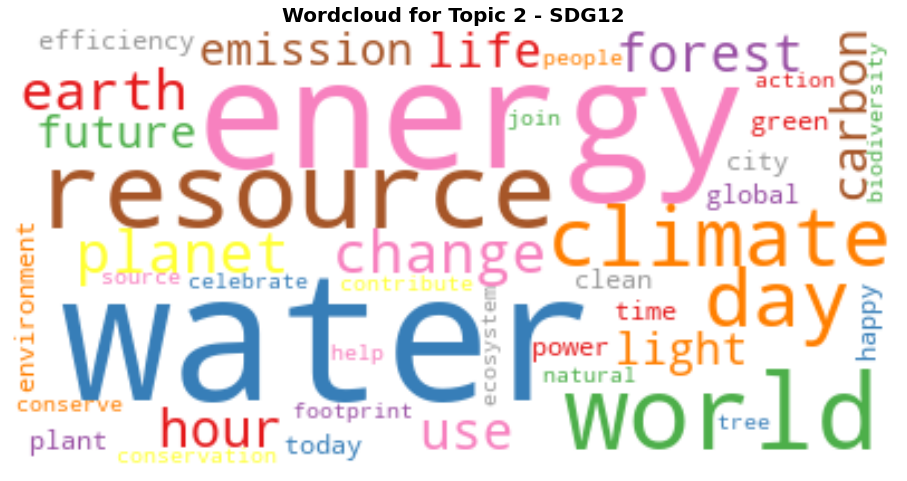

In [185]:
# wordcloud for each topic -SDG12
topic = 0 
num_topics = 3

while topic < num_topics:
    # extract top 50 words per topic, map each word to its frequency in a topic
    topic_words_freq = dict(sdg12_ldamodel.show_topic(topic, topn = 50)) 
   
    # generate Word Cloud for topic using the dictionary
    plt.figure(figsize = (16,12))
    wordcloud = WordCloud(background_color ='white', min_font_size = 10, max_font_size = 80).generate_from_frequencies(topic_words_freq) 

    plt.imshow(wordcloud.recolor(colormap = 'Set1' , random_state = 1), interpolation = 'bilinear')
    plt.title('Wordcloud for Topic ' + str(topic) + ' - SDG12', fontsize = 20, fontweight = 'bold')
    plt.axis('off')
    plt.show()
    topic += 1

### Frequently used hashtags among top 25% Tweets of each topic - SDG12

In [133]:
print('Frequently-used hashtags in top Tweets of Topic0 - SDG12')
sdg12_t0_top_hashtags = Counter([item for sublist in sdg12_t0_top['hashtag'] for item in sublist])
sdg12_t0_hashtags20 = pd.DataFrame(sdg12_t0_top_hashtags.most_common(20))
sdg12_t0_hashtags20.columns = ['Top positive hashtags', 'Frequency']
sdg12_t0_hashtags20.style.background_gradient(cmap = 'Blues')

Frequently-used hashtags in top Tweets of Topic0 - SDG12


In [134]:
print('Frequently-used hashtags in top Tweets of Topic1 - SDG12')
sdg12_t1_top_hashtags = Counter([item for sublist in sdg12_t1_top['hashtag'] for item in sublist])
sdg12_t1_hashtags20 = pd.DataFrame(sdg12_t1_top_hashtags.most_common(20))
sdg12_t1_hashtags20.columns = ['Top positive hashtags', 'Frequency']
sdg12_t1_hashtags20.style.background_gradient(cmap = 'Blues')

Frequently-used hashtags in top Tweets of Topic1 - SDG12


In [135]:
print('Frequently-used hashtags in top Tweets of Topic2 - SDG12')
sdg12_t2_top_hashtags = Counter([item for sublist in sdg12_t2_top['hashtag'] for item in sublist])
sdg12_t2_hashtags20 = pd.DataFrame(sdg12_t2_top_hashtags.most_common(20))
sdg12_t2_hashtags20.columns = ['Top positive hashtags', 'Frequency']
sdg12_t2_hashtags20.style.background_gradient(cmap = 'Blues')

Frequently-used hashtags in top Tweets of Topic2 - SDG12


### Frequently used words among top 25% Tweets of each topic - SDG12

In [136]:
print('Frequently-used words in top Tweets of Topic0 - SDG12')
sdg12_t0_top_words = Counter([item for sublist in sdg12_t0_top['content_cleaned'] for item in sublist])
sdg12_t0_words20 = pd.DataFrame(sdg12_t0_top_words.most_common(20))
sdg12_t0_words20.columns = ['Top words', 'Frequency']
sdg12_t0_words20.style.background_gradient(cmap = 'Blues')

Frequently-used words in top Tweets of Topic0 - SDG12


In [137]:
print('Frequently-used words in top Tweets of Topic1 - SDG12')
sdg12_t1_top_words = Counter([item for sublist in sdg12_t1_top['content_cleaned'] for item in sublist])
sdg12_t1_words20 = pd.DataFrame(sdg12_t1_top_words.most_common(20))
sdg12_t1_words20.columns = ['Top words', 'Frequency']
sdg12_t1_words20.style.background_gradient(cmap = 'Blues')

Frequently-used words in top Tweets of Topic1 - SDG12


In [138]:
print('Frequently-used words in top Tweets of Topic2 - SDG12')
sdg12_t2_top_words = Counter([item for sublist in sdg12_t2_top['content_cleaned'] for item in sublist])
sdg12_t2_words20 = pd.DataFrame(sdg12_t2_top_words.most_common(20))
sdg12_t2_words20.columns = ['Top words', 'Frequency']
sdg12_t2_words20.style.background_gradient(cmap = 'Blues')

Frequently-used words in top Tweets of Topic2 - SDG12


### 6.2.1 BN: Building LDA models

#### LDA model - BN

#### BN First model: num_topics = 2

In [139]:
t0 = time.time()

np.random.seed(1) 

bn_ldamodel = LdaMulticore(bn_bow, 
                    id2word = bn_dictionary, 
                    num_topics = 2, 
                    chunksize = 4000, 
                    batch = True,
                    minimum_probability = 0.01,
                    iterations = 300, 
                    passes = 100)                  

t1 = time.time()
print("time for 200 passes: ",(t1-t0)," seconds")

time for 200 passes:  27.298683881759644  seconds


In [329]:
bn_ldamodel.show_topics(num_words = 10, formatted = False)

[(0,
  [('friday', 0.10486532),
   ('consumption', 0.0633396),
   ('happy', 0.0581281),
   ('planet', 0.048396047),
   ('consumerism', 0.04754348),
   ('waste', 0.043474127),
   ('sustainable', 0.043432288),
   ('overconsumption', 0.041788783),
   ('consumer', 0.03514602),
   ('part', 0.031002073)]),
 (1,
  [('day', 0.13429195),
   ('nothing', 0.12968168),
   ('today', 0.117770106),
   ('buy', 0.057892367),
   ('thing', 0.054848135),
   ('shop', 0.040686935),
   ('good', 0.039034903),
   ('people', 0.03382678),
   ('local', 0.02727944),
   ('shopping', 0.02636022)])]

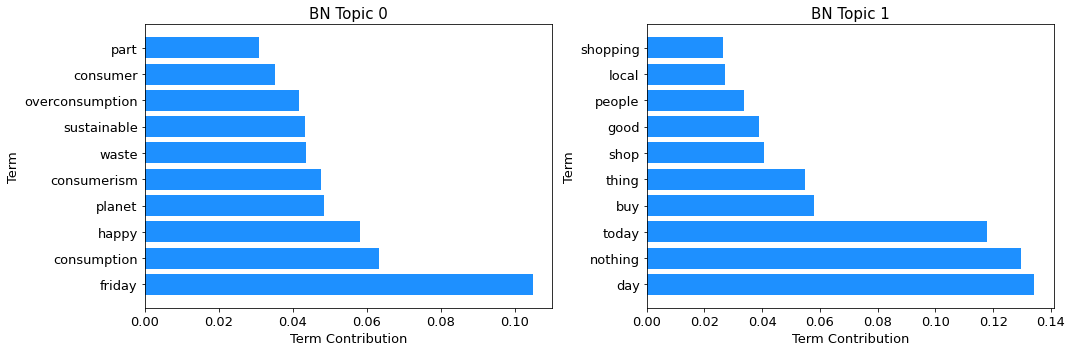

In [331]:
# topic term contribution - BN
bn_topic_words = bn_ldamodel.show_topics(num_words=10, formatted=False)

terms = []
term_contributions = []
for topic, word_contribs in bn_topic_words:
    topic_terms = [word for word, _ in word_contribs]
    term_contrib = [contribution for _, contribution in word_contribs]
    terms.append(topic_terms)
    term_contributions.append(term_contrib)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.barh(terms[i], term_contributions[i], color='dodgerblue')
    ax.set_title('BN Topic ' + str(i), fontsize = 15)
    ax.set_xlabel('Term Contribution', fontsize = 13)
    ax.set_ylabel('Term', fontsize = 13)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)

plt.tight_layout()

plt.show()

#### BN Second model, num_topics = 3

In [140]:
t0 = time.time()

np.random.seed(1) # setting up random seed to get the same results

bn_ldamodel2 = LdaMulticore(bn_bow, 
                    id2word = bn_dictionary, 
                    num_topics = 3, 
                    chunksize = 4000, #n. tweets processed, high n improves efficiency
                    batch = True,
                    minimum_probability = 0.01,
                    iterations = 300, #max iter for LDA model to converge
                    passes = 100)  #number of times the entire corpus will be traversed during training, increase performance and training time                

t1 = time.time()
print("time for 200 passes: ",(t1-t0)," seconds")

time for 200 passes:  31.917183876037598  seconds


In [332]:
bn_ldamodel2.show_topics(num_words = 10, formatted = False)

[(0,
  [('friday', 0.14664163),
   ('consumption', 0.08094493),
   ('planet', 0.061927624),
   ('waste', 0.055564187),
   ('overconsumption', 0.053434364),
   ('sustainable', 0.05113055),
   ('consumer', 0.044913225),
   ('consumerism', 0.041701127),
   ('part', 0.03955484),
   ('money', 0.036385622)]),
 (1,
  [('day', 0.21749824),
   ('today', 0.16972534),
   ('nothing', 0.123564124),
   ('shop', 0.058571823),
   ('thing', 0.053080034),
   ('shopping', 0.041296978),
   ('support', 0.039049625),
   ('anything', 0.034834314),
   ('year', 0.03401248),
   ('tomorrow', 0.030505212)]),
 (2,
  [('buy', 0.11431679),
   ('happy', 0.10438957),
   ('good', 0.07765575),
   ('nothing', 0.07506123),
   ('people', 0.06725807),
   ('local', 0.053928856),
   ('celebrate', 0.05088734),
   ('gift', 0.04645432),
   ('stuff', 0.042017058),
   ('help', 0.040505297)])]

### 6.2.2 BN: Model evaluation - model perplexity and coherence score 

#### Coherence and perplexity - BN 3 Topics

In [76]:
# bn: 3 topics
get_coherence_score(bn_ldamodel2,bn_bigrams,bn_dictionary,bn_bow)


Coherence Score:  0.3209379723698553

Perplexity:  -3.896229245904237


#### Intertopic distance map - BN 3 Topics

In [141]:
# bn: 3 topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model = bn_ldamodel2, corpus = bn_bow, dictionary = bn_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.300020  0.096649       1        1  38.113359
1     -0.054381 -0.275741       2        1  34.709661
2     -0.245638  0.179092       3        1  27.176980, topic_info=             Term        Freq       Total Category  logprob  loglift
24          today  153.000000  153.000000  Default  30.0000  30.0000
6             day  202.000000  202.000000  Default  29.0000  29.0000
36         friday  133.000000  133.000000  Default  28.0000  28.0000
7             buy   79.000000   79.000000  Default  27.0000  27.0000
13          happy   72.000000   72.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
51  environmental    0.352486   21.052577   Topic3  -7.5584  -2.7870
32        holiday    0.406912   25.260583   Topic3  -7.4148  -2.8256
17           year    0.618782   51.171785   Topic3  -6.9956  -3.1124
36         friday    0.697075  133.838551   Topic3  -6.8765  -3.9547
33    consumerism    0.443439   57.551676   Topic3  -7.3288  -3.5631

[132 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
12        2  0.967048   anything
7         3  0.989666        buy
0         3  0.978327       cant
34        3  0.977807  celebrate
37        1  0.949942    consume
...     ...       ...        ...
16        3  0.623098        way
46        1  0.967826      world
17        1  0.390840       year
17        2  0.605803       year
17        3  0.019542       year

[78 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

#### Coherence and perplexity - BN 2 Topics

In [78]:
# bn: 2 topics
get_coherence_score(bn_ldamodel,bn_bigrams,bn_dictionary,bn_bow)


Coherence Score:  0.3259761576317964

Perplexity:  -3.8399172630607774


#### Intertopic distance map - BN 3 Topics

In [142]:
# bn: 2 topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model = bn_ldamodel, corpus = bn_bow, dictionary = bn_dictionary)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.255285  0.0       1        1  51.670984
0     -0.255285  0.0       2        1  48.329016, topic_info=            Term        Freq       Total Category  logprob  loglift
24         today  153.000000  153.000000  Default  30.0000  30.0000
9        nothing  176.000000  176.000000  Default  29.0000  29.0000
36        friday  137.000000  137.000000  Default  28.0000  28.0000
28   consumption   75.000000   75.000000  Default  27.0000  27.0000
13         happy   69.000000   69.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
17          year   28.142019   51.909096   Topic2  -3.7540   0.1149
20  black_friday    0.492363    0.978972   Topic2  -7.7998   0.0399
21          deal   12.743786   25.452273   Topic2  -4.5462   0.0354
18          join   11.777018   29.333842   Topic2  -4.6251  -0.1855
6            day   38.040120  203.846750   Topic2  -3.4527  -0.9516

[93 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
12        1  0.996183  anything
12        2  0.031131  anything
7         1  0.987895       buy
7         2  0.013172       buy
0         1  0.984418      cant
...     ...       ...       ...
16        2  0.980768       way
46        1  0.037623     world
46        2  0.978207     world
17        1  0.462347      year
17        2  0.539405      year

[106 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

### 6.2.3 BN: Interpretation and analysis

### Proportions of topics - BN

#### Compute the major topics and topic contribution across Tweets

In [143]:
bn_all_topics = bn_ldamodel.get_document_topics(bn_bow)

all_topics_csr = gensim.matutils.corpus2csc(bn_all_topics)

# topic ids and respective probability
all_topics_numpy = all_topics_csr.T.toarray() 

# select topic id with max probability
major_topic = [np.argmax(arr) for arr in all_topics_numpy] 
topic_contribution = [arr[idx] for arr, idx in zip(all_topics_numpy, major_topic)]

bn_dup['lda_topic'] = major_topic
bn_dup['topic_contribution'] = topic_contribution

bn_dup['topic_contribution'] = bn_dup['topic_contribution'].round(3)

In [144]:
bn_topic = bn_dup['lda_topic'].value_counts()
print('Topics of BN tweets:')
print(bn_topic)

Topics of BN tweets:
0    560
1    374
Name: lda_topic, dtype: int64


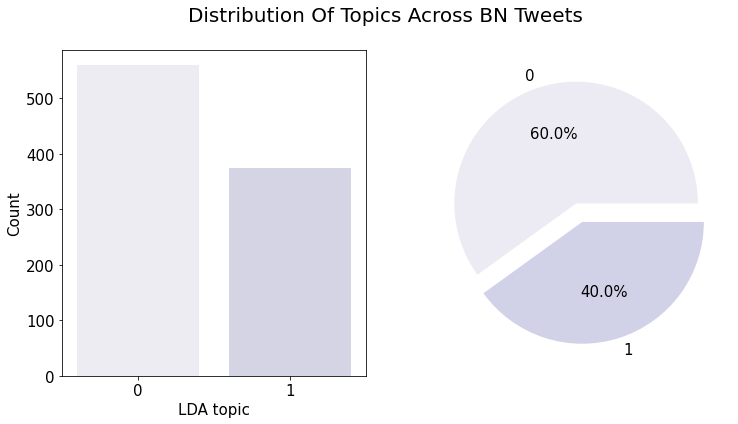

In [208]:
# bar and pie charts of topic distribution - BN
fig, ax = plt.subplots(1,2)

colors = sns.color_palette('Purples')

sns.countplot(x = 'lda_topic', data = bn_dup, ax = ax[0], palette = colors) 
ax[0].tick_params(axis = 'both', labelsize = 15)


ax[1].pie(bn_topic, labels = bn_topic.index, 
          explode = [0.08,0.08], colors = colors,
          textprops = {'fontsize': 15}, autopct = '%1.1f%%')

ax[0].tick_params(axis = 'both', labelsize = 15)
ax[0].set_xlabel('LDA topic', fontsize = 15)
ax[0].set_ylabel('Count', fontsize = 15)

fig.set_figwidth(12)
fig.set_figheight(6)
fig.suptitle('Distribution Of Topics Across BN Tweets', fontsize = 20)
plt.show()

In [145]:
bn_topic_grouped = bn_dup.groupby(['yearMonth', 'lda_topic']).size().unstack()

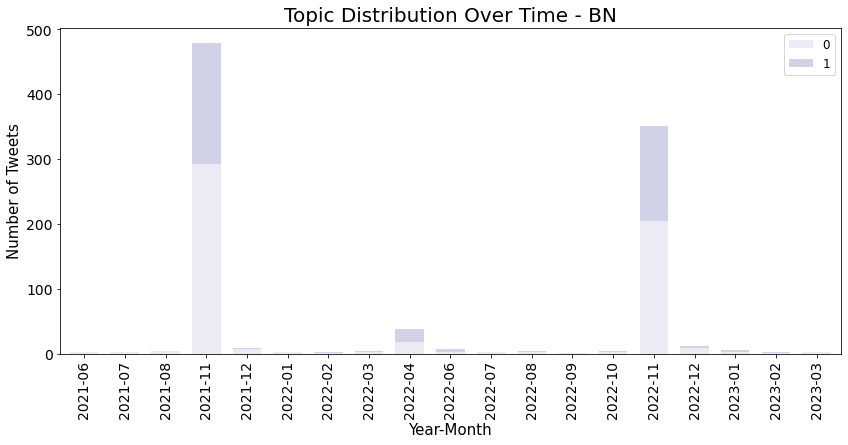

In [341]:
# stacked bar chart of topic distribution across year-month - BN
colors = sns.color_palette('Purples')

fig, ax = plt.subplots()
bn_topic_grouped.plot(kind ='bar', stacked = True, ax = ax, width = 0.7, align = 'center', color = [colors[topic] for topic in bn_topic_grouped])

ax.set_xlabel('Year-Month', fontsize = 15)
ax.set_ylabel('Number of Tweets', fontsize = 15)
ax.set_title('Topic Distribution Over Time - BN', fontsize = 20)
plt.xticks(fontsize = 14, rotation = 90, ha = 'center')
plt.yticks(fontsize = 14)
ax.legend(fontsize = 'large')

fig.set_figwidth(14)
fig.set_figheight(6)

plt.show()

### Representative Tweets for each topic - BN

In [146]:
bn_t0 = bn_dup[bn_dup['lda_topic'] == 0]
bn_t1 = bn_dup[bn_dup['lda_topic'] == 1]

In [345]:
print('bn_topic0')
bn_t0['topic_contribution'].describe()

bn_topic0


count    558.000000
mean       0.638952
std        0.143808
min        0.500000
25%        0.500000
50%        0.603000
75%        0.750000
max        0.944000
Name: topic_contribution, dtype: float64

In [346]:
print('bn_topic1')
bn_t1['topic_contribution'].describe()

bn_topic1


count    376.000000
mean       0.741016
std        0.117969
min        0.500000
25%        0.656750
50%        0.749000
75%        0.833000
max        0.951000
Name: topic_contribution, dtype: float64

#### Select the top 25% Tweets of each topic

In [147]:
bn_t0_top = bn_t0[bn_t0['topic_contribution'] >= 0.75]
bn_t1_top = bn_t1[bn_t1['topic_contribution'] >= 0.833]

In [401]:
# most representative tweets in each topic - BN
print(Fore.BLUE + 'Two most representative Tweet for Topic 0 - BN:', Fore.RESET)
print(bn_t0_top.nlargest(1, 'topic_contribution')['content'].values[0])
print()
print(bn_t0_top.nlargest(2, 'topic_contribution')['content'].values[1])
print()
print(Fore.BLUE + 'Two most representative Tweet for Topic 1 - BN:', Fore.RESET)
print(bn_t1_top.nlargest(1, 'topic_contribution')['content'].values[0])
print()
print(bn_t1_top.nlargest(2, 'topic_contribution')['content'].values[1])

Two most representative Tweet for Topic 0 - BN: 
#BuyNothingDay is part of a movement against consumerism, urging the world to change their purchasing habits, and to consume and produce less. It is also a great way to save money, enjoy life, and take in the beauty of #NewMexico! #BuyNothing

Hey Waste Warriors! This Nov. 27 is #BuyNothingDay #BuyNothing! A time to be mindful of consumerism. Therere many ways to take action against over-consumption so wed love to hear yours! How do you combat over-consumption in our consumer economy?
#responsibleconsumption #greeneconomy #buynothing

Two most representative Tweet for Topic 1 - BN: 
tis the season of shopping for things we don't need. This year, consider joining the #BuyNothingDay #BuyNothing challenge. If you need something or want to shop for gifts, we encourage shopping secondhand and supporting small, local businesses. (credit: @1millionwomen) 

Got a free TV from my local #BuyNothing group, shown with my free yoga mat & free shelves

### Wordcloud for each topic - BN

In [148]:
bn_t0_string = ' '.join(bn_t0['content_cleaned_sa'].str.lower())
bn_t0_string = re.sub(r'\b\w\b', '', bn_t0_string)
bn_t1_string = ' '.join(bn_t1['content_cleaned_sa'].str.lower())
bn_t1_string = re.sub(r'\b\w\b', '', bn_t1_string)

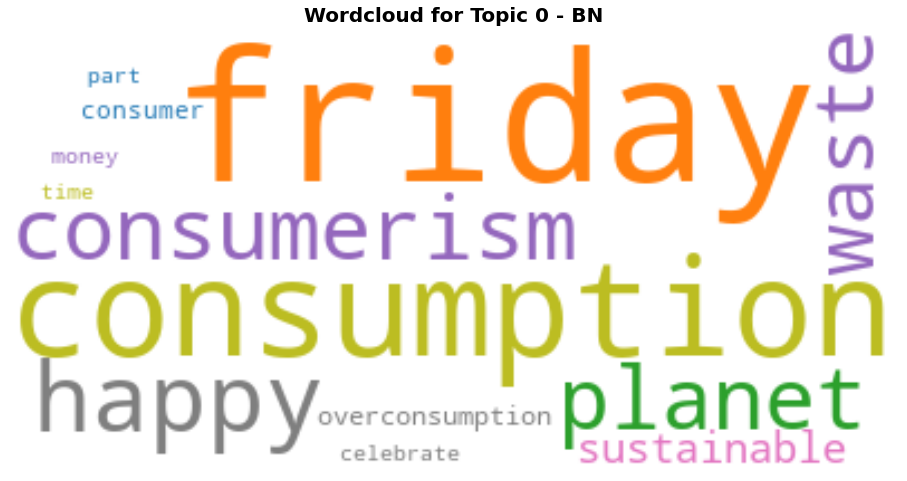

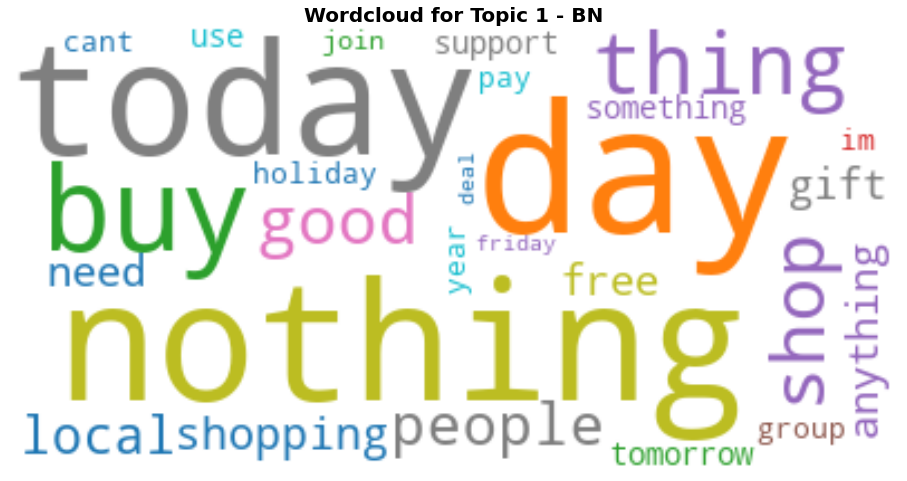

In [351]:
# wordcloud for each topic
topic = 0 
num_topics = 2

while topic < num_topics:
    # Extract top words from topics, 50 words per topic. Map each word to its frequency in a topic
    topic_words_freq = dict(bn_ldamodel.show_topic(topic, topn = 50)) 
   
    # Generate Word Cloud for topic using the dictionary
    plt.figure(figsize = (16,12))
    wordcloud = WordCloud(background_color ='white', min_font_size = 10, max_font_size = 80).generate_from_frequencies(topic_words_freq) 

    plt.imshow(wordcloud.recolor(colormap = 'tab10' , random_state = 1), interpolation = 'bilinear')
    plt.title('Wordcloud for Topic ' + str(topic) + ' - BN', fontsize = 20, fontweight = 'bold')
    plt.axis('off')
    plt.show()
    topic += 1

### Frequently used hashtags among top 25% Tweets of each topic - BN

In [149]:
print('Frequently-used hashtags in top Tweets of Topic0 - BN')
bn_t0_top_hashtags = Counter([item for sublist in bn_t0_top['hashtag'] for item in sublist])
bn_t0_hashtags20 = pd.DataFrame(bn_t0_top_hashtags.most_common(20))
bn_t0_hashtags20.columns = ['Top positive hashtags', 'Frequency']
bn_t0_hashtags20.style.background_gradient(cmap = 'Purples')

Frequently-used hashtags in top Tweets of Topic0 - BN


In [150]:
print('Frequently-used hashtags in top Tweets of Topic1 - BN')
bn_t1_top_hashtags = Counter([item for sublist in bn_t1_top['hashtag'] for item in sublist])
bn_t1_hashtags20 = pd.DataFrame(bn_t1_top_hashtags.most_common(20))
bn_t1_hashtags20.columns = ['Top positive hashtags', 'Frequency']
bn_t1_hashtags20.style.background_gradient(cmap = 'Purples')

Frequently-used hashtags in top Tweets of Topic1 - BN


### Frequently used words among top 25% Tweets of each topic - BN

In [151]:
print('Frequently-used words in top Tweets of Topic0 - BN')
bn_t0_top_words = Counter([item for sublist in bn_t0_top['content_cleaned'] for item in sublist])
bn_t0_words20 = pd.DataFrame(bn_t0_top_words.most_common(20))
bn_t0_words20.columns = ['Top words', 'Frequency']
bn_t0_words20.style.background_gradient(cmap = 'Purples')

Frequently-used words in top Tweets of Topic0 - BN


In [152]:
print('Frequently-used words in top Tweets of Topic1 - BN')
bn_t1_top_words = Counter([item for sublist in bn_t1_top['content_cleaned'] for item in sublist])
bn_t1_words20 = pd.DataFrame(bn_t1_top_words.most_common(20))
bn_t1_words20.columns = ['Top words', 'Frequency']
bn_t1_words20.style.background_gradient(cmap = 'Purples')

Frequently-used words in top Tweets of Topic1 - BN


### Topic X Sentiment Polarity

In [160]:
sdg12_t0_polarity = sdg12_t0['sentimentPolarity'].value_counts()
sdg12_t1_polarity = sdg12_t1['sentimentPolarity'].value_counts()
sdg12_t2_polarity = sdg12_t2['sentimentPolarity'].value_counts()

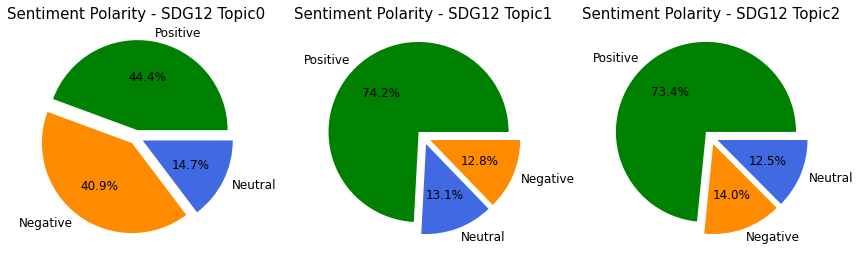

In [254]:
# pie chart - distribution of sentiment polarity in each topic - SDG12
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

colors = {'Positive': 'green', 'Negative': 'darkorange', 'Neutral': 'royalblue'}

axes[0].pie(sdg12_t0_polarity, labels = sdg12_t0_polarity.index, autopct = '%1.1f%%', explode = [0.08, 0.08, 0.08],
            colors = [colors[polarity] for polarity in sdg12_t0_polarity.index], textprops = {'fontsize': 12})
axes[0].set_title('Sentiment Polarity - SDG12 Topic0', fontsize = 15)
 
axes[1].pie(sdg12_t1_polarity, labels = sdg12_t1_polarity.index, autopct = '%1.1f%%', explode = [0.08, 0.08, 0.08],
            colors = [colors[polarity] for polarity in sdg12_t1_polarity.index], textprops = {'fontsize': 12})
axes[1].set_title('Sentiment Polarity - SDG12 Topic1', fontsize = 15)

axes[2].pie(sdg12_t2_polarity, labels = sdg12_t2_polarity.index, autopct = '%1.1f%%', explode = [0.08, 0.08, 0.08],
            colors = [colors[polarity] for polarity in sdg12_t2_polarity.index], textprops = {'fontsize': 12})
axes[2].set_title('Sentiment Polarity - SDG12 Topic2', fontsize = 15)

plt.tight_layout()

plt.show()

In [158]:
bn_t0_polarity = bn_t0['sentimentPolarity'].value_counts()
bn_t1_polarity = bn_t1['sentimentPolarity'].value_counts()

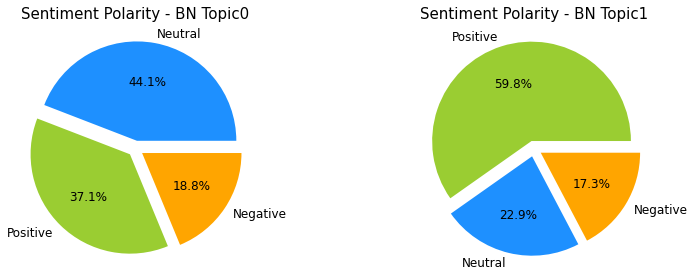

In [356]:
# pie chart - distribution of sentiment polarity in each topic - SDG12
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

colors = {'Positive': 'yellowgreen', 'Negative': 'orange', 'Neutral': 'dodgerblue'}

axes[0].pie(bn_t0_polarity, labels = bn_t0_polarity.index, autopct = '%1.1f%%', explode = [0.08, 0.08, 0.08],
            colors = [colors[polarity] for polarity in bn_t0_polarity.index], textprops = {'fontsize': 12})
axes[0].set_title('Sentiment Polarity - BN Topic0', fontsize = 15)
 
axes[1].pie(bn_t1_polarity, labels = bn_t1_polarity.index, autopct = '%1.1f%%', explode = [0.08, 0.08, 0.08],
            colors = [colors[polarity] for polarity in bn_t1_polarity.index], textprops = {'fontsize': 12})
axes[1].set_title('Sentiment Polarity - BN Topic1', fontsize = 15)


plt.tight_layout()

plt.show()

#### Most negative Tweets in Topic1 - BN

In [163]:
bn_t1_neg = bn_t1[bn_t1['sentimentPolarity'] == 'Negative']

In [512]:
print(Fore.BLUE + 'Two most negative Tweet for Topic 1 - BN:', Fore.RESET)
print(bn_t1.nlargest(1, 'negativeSentiment')['content'].values[0])
print('Negativity: ' + str(bn_t1.nlargest(1, 'negativeSentiment')['negativeSentiment'].values[0]))
print()
print(bn_t1.nlargest(2, 'negativeSentiment')['content'].values[1])
print('Negativity: ' + str(bn_t1.nlargest(2, 'negativeSentiment')['negativeSentiment'].values[1]))
print()
print(bn_t1.nlargest(3, 'negativeSentiment')['content'].values[2])
print('Negativity: ' + str(bn_t1.nlargest(3, 'negativeSentiment')['negativeSentiment'].values[2]))

Two most negative Tweet for Topic 1 - BN: 
Practice #consciousconsumerism and stop buying unnecessary things to fight climate crisis! #buynothing
Negativity: 0.64

Organizing to stop the #climatecrisis and anti-capitalism are not branding exercises for your lame ass group (thats not even anti-capitalist).  

#BuyNothingDay #BuyNothing #ClimateAction
Negativity: 0.621

Why We Hate the Holidays
#LateStageConsumerism #LateStageCapitalism #FuckBlackFriday #BuyNothingDay #BuyNothing 
Negativity: 0.587


# 7. Similarity measure

### 7.1 Prepare the topic words for similarity measure

#### Join topic words of each topic into a list of strings, each topic is represented by one row in a dataframe

In [164]:
bn_topics = bn_ldamodel.show_topics(num_topics = 2, num_words = 10, formatted = False)
sdg12_topics = sdg12_ldamodel.show_topics(num_topics = 3, num_words = 10, formatted = False)

In [165]:
sdg12_topics_df = pd.DataFrame(columns = ['topic', 'topicWords'])
for topic_id, topic_words in sdg12_topics:
    keywords = ', '.join([word for word, _ in topic_words])
    sdg12_topics_df = sdg12_topics_df.append({'topic': topic_id, 'topicWords': keywords}, ignore_index=True)

In [166]:
bn_topics_df = pd.DataFrame(columns = ['topic', 'topicWords'])
for topic_id, topic_words in bn_topics:
    keywords = ', '.join([word for word, _ in topic_words])
    bn_topics_df = bn_topics_df.append({'topic': topic_id, 'topicWords': keywords}, ignore_index=True)

In [219]:
bn_topics_df 

topic  \
0     0   
1     1   

                                                                                            topicWords  
0  friday, consumption, happy, planet, consumerism, sustainable, waste, overconsumption, consumer, day  
1                                 day, nothing, today, buy, thing, shop, good, people, local, shopping

In [220]:
sdg12_topics_df

topic  \
0     0   
1     1   
2     2   

                                                                                                      topicWords  
0                                           waste, food, plastic, recycle, use, reuse, year, pollution, day, new  
1  sustainable, consumption, production, responsible, resource, future, sustainability, action, consumer, planet  
2                               water, energy, climate, economy, resource, change, circular, emission, use, hour

In [167]:
sdg12_topics_df['topic'] = df = pd.DataFrame({'topic': ["sdg12_0","sdg12_1","sdg12_2"]})

In [168]:
bn_topics_df['topic'] = df = pd.DataFrame({'topic': ["bn_0","bn_1"]})

In [169]:
merge = [sdg12_topics_df, bn_topics_df]
topics_df = pd.concat(merge)

In [253]:
# a resulting dataframe consisting of 3 topics from SDG12, and 2 topics from BN
topics_df

topic  \
0  sdg12_0   
1  sdg12_1   
2  sdg12_2   
0     bn_0   
1     bn_1   

                                                                                                      topicWords  
0                                           waste, food, plastic, recycle, use, reuse, year, pollution, day, new  
1  sustainable, consumption, production, responsible, resource, future, sustainability, action, consumer, planet  
2                               water, energy, climate, economy, resource, change, circular, emission, use, hour  
0            friday, consumption, happy, planet, consumerism, sustainable, waste, overconsumption, consumer, day  
1                                           day, nothing, today, buy, thing, shop, good, people, local, shopping

In [170]:
documents_sc = topics_df['topicWords'].tolist()
documents_sc = [word_tokenize(doc) for doc in documents_sc]

#### Dictionary

In [171]:
dictionary_sc = corpora.Dictionary(documents_sc)

#### BoW

In [172]:
corpus_sc = [dictionary_sc.doc2bow(doc) for doc in documents_sc]

#### Tfidf

In [173]:
tfidf_sc = models.TfidfModel(corpus_sc)
corpus_tfidf_sc = tfidf_sc[corpus_sc]

#### Word2Vec

In [174]:
# word vectors trained on Twitter data, takes some time to run
w2v_model_sc = api.load('glove-twitter-25')

#### Similarity index and similarity matrix

In [175]:
# construst a similarity index using pretrained Twitter word vectors
similarity_index = WordEmbeddingSimilarityIndex(w2v_model_sc)

# combine word embedding with term and document frequencies
similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary_sc, tfidf_sc)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 31.30it/s]


### 7.2 Compute soft cosine similarity

In [176]:
similarities = []
for i in range(len(topics_df)):
    for j in range(i + 1, len(topics_df)):
        topic1 = corpus_tfidf_sc[i]
        topic2 = corpus_tfidf_sc[j]
        index = SoftCosineSimilarity(topic1, similarity_matrix)
        similarity_score = index[topic2]
        similarities.append((i, j, similarity_score))

In [178]:
for i, j, score in similarities:
    print(f"Similarity between topics {i} and {j}: {score}")

Similarity between topics 0 and 1: 0.08217568695545197
Similarity between topics 0 and 2: 0.36258745193481445
Similarity between topics 0 and 3: 0.3795417845249176
Similarity between topics 0 and 4: 0.49367085099220276
Similarity between topics 1 and 2: 0.388367623090744
Similarity between topics 1 and 3: 0.3633085787296295
Similarity between topics 1 and 4: 0.07488536089658737
Similarity between topics 2 and 3: 0.3859791159629822
Similarity between topics 2 and 4: 0.18491065502166748
Similarity between topics 3 and 4: 0.3686937689781189


In [367]:
similarities

[(0, 1, array(0.08217569, dtype=float32)),
 (0, 2, array(0.36258745, dtype=float32)),
 (0, 3, array(0.37954178, dtype=float32)),
 (0, 4, array(0.49367085, dtype=float32)),
 (1, 2, array(0.38836762, dtype=float32)),
 (1, 3, array(0.36330858, dtype=float32)),
 (1, 4, array(0.07488536, dtype=float32)),
 (2, 3, array(0.38597912, dtype=float32)),
 (2, 4, array(0.18491066, dtype=float32)),
 (3, 4, array(0.36869377, dtype=float32))]

In [368]:
score_matrix = np.zeros((3,2))

for row, col, value in similarities:
    if row < 3 and col >= 3 and col <= 4:
        score_matrix[row, col-3] = np.around(value, decimals = 3)

In [369]:
print(score_matrix)

[[0.38       0.49399999]
 [0.36300001 0.075     ]
 [0.38600001 0.185     ]]


In [374]:
row_label = ['SDG12 T0', 'SDG12 T1', 'SDG12 T2']
col_label = ['BN T0', 'BN T1']

score_df = pd.DataFrame(score_matrix, index = row_label, columns = col_label)

In [375]:
# print similarity score in a matrix
score_df

BN T0  BN T1
SDG12 T0  0.380  0.494
SDG12 T1  0.363  0.075
SDG12 T2  0.386  0.185